# Jupyter Notebook to Analyze ERA5 100m Wind data

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

Product type:Reanalysis

Variable:100m u-component of wind, 100m v-component of wind, 10m u-component of wind, 10m v-component of wind

Year:2021, 2022, 2023

Month:January, February, March, April, May, June, July, August, September, October, November, December

Day:01, 02, 03, 04, 05, 06, 07, 08, 09, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31

Time:00:00, 01:00, 02:00, 03:00, 04:00, 05:00, 06:00, 07:00, 08:00, 09:00, 10:00, 11:00, 12:00, 13:00, 14:00, 15:00, 16:00, 17:00, 18:00, 19:00, 20:00, 21:00, 22:00, 23:00

Sub-region extraction:North 55°, West 6°, South 47°, East 15°

Format:NetCDF (experimental)

In [2]:
#f=xr.open_dataset('C:/Users/Anwender/Documents/GitHub/RiVaPy_development/ERA5_Data_netCDF/adaptor.mars.internal-1698057309.422591-30637-3-8c127153-a2da-4e09-9756-06435d022dfb.nc')
f1 = xr.open_dataset('/Users/angelina/Documents/Arbeit/ClimateRisk/dataset_2021-2023.nc')
f2 = xr.open_dataset('/Users/angelina/Documents/Arbeit/ClimateRisk/dataset_2018-2020.nc')
f3 = xr.open_dataset('/Users/angelina/Documents/Arbeit/ClimateRisk/dataset_2015-2017.nc')
f4 = xr.open_dataset('/Users/angelina/Documents/Arbeit/ClimateRisk/dataset_2012-2014.nc')

f = xr.concat([f4, f3, f2, f1], dim='time')

In [3]:
lons = f.variables['longitude'][:]  # longitude
lats = f.variables['latitude'][:]  # latitude
u100 = f.variables['u100'][:,:,:,0] # u-wind at 100m height
v100 = f.variables['v100'][:,:,:,0]  # v-wind at 100m height
u10 = f.variables['u10'][:,:,:,0]  # u-wind at 10m height
v10 = f.variables['v10'][:,:,:,0]  # v-wind at 10m height
time = f.variables['time'][:]

ws100 = np.array(np.sqrt(u100*u100+v100*v100))
ws10 = np.array(np.sqrt(u10*u10+v10*v10))

#print(lons)
#print(u100)
##f.close()
##print(f['v10'])

### Plots

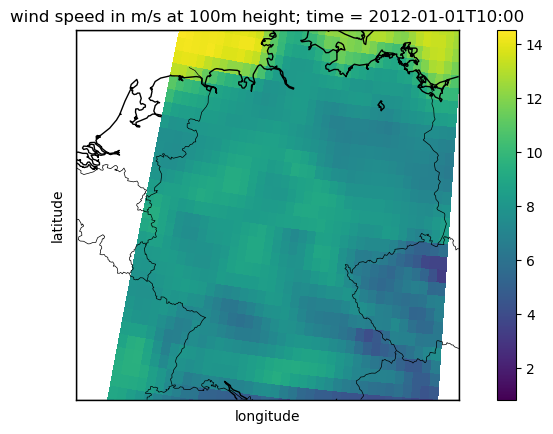

In [26]:
m = Basemap(llcrnrlon=5,llcrnrlat=47,urcrnrlon=15,urcrnrlat=55,
             resolution='i', projection='tmerc', lat_0 = 80, lon_0 = 20)

lon, lat = np.meshgrid(lons, lats)
xi, yi = m(lon, lat)

#define two locations
loc1 = 15
loc2 = 25
#loc3 = 1
#loc4 = 16

x1,y1 = m(lon[loc1,loc1], lat[loc1,loc1])
x2,y2 = m(lon[loc2,loc2], lat[loc2,loc2])
#x3,y3 = m(lon[loc3,loc3], lat[loc3,loc3])
#x4,y4 = m(lon[loc4,loc4], lat[loc4,loc4])

cs = m.pcolor(xi,yi,np.squeeze(ws100[10,:,:]))

m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
cbar = m.colorbar(cs, location='right', pad="10%")
tt = np.array(time[10], dtype='datetime64[m]') #10 & 4378
plt.title('wind speed in m/s at 100m height; time = '+str(tt))
plt.xlabel('longitude')
plt.ylabel('latitude')
#plt.plot(xi[lon1,lon1], yi[lat1,lat1],'ro')
#plt.plot(x1, y1,'ro')
#plt.plot(x2, y2,'ro')
#plt.plot(x3, y3,'ro')
#plt.plot(x4, y4,'ro')
plt.show()

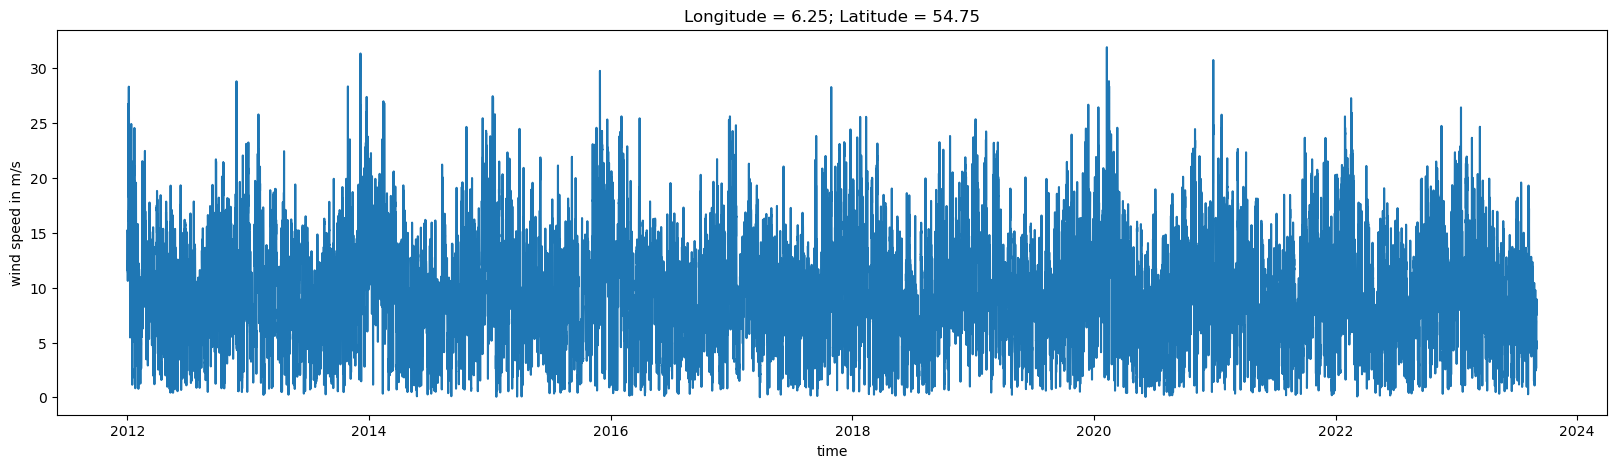

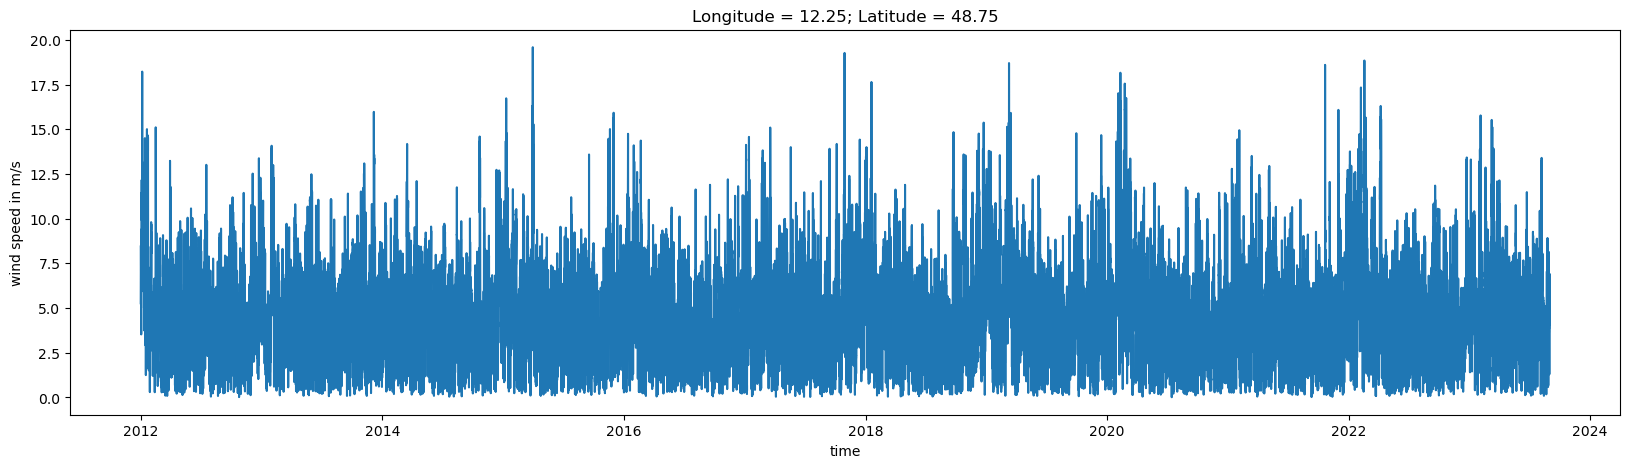

In [27]:
loc1=1
plt.figure(figsize=(20,5))
plt.plot(time[:],ws100[:,loc1,loc1])
sel_lon = np.array(lons[loc1])
sel_lat = np.array(lats[loc1])
plt.title('Longitude = '+str(sel_lon)+'; Latitude = '+str(sel_lat))
plt.ylabel('wind speed in m/s')
plt.xlabel('time')
plt.show()

plt.figure(figsize=(20,5))
plt.plot(time[:],ws100[:,loc2,loc2],)
sel_lon = np.array(lons[loc2])
sel_lat = np.array(lats[loc2])
plt.title('Longitude = '+str(sel_lon)+'; Latitude = '+str(sel_lat))
plt.ylabel('wind speed in m/s')
plt.xlabel('time')
#plt.yscale('log')
plt.show()

## Deseasonalization, Principal Component Analysis and Correlation

In [4]:
from scipy.optimize import curve_fit 

def time_as_year_fraction(time):
    first_date=time[:][0].values 
    diff_in_sec = ((time[:][:].values-first_date)) / np.timedelta64(1, 's')
    time_frac = diff_in_sec / (365*24*60*60) #days, hours, minutes, seconds
    return time_frac
    #year = first_date.astype('datetime64[Y]').astype(int) + 1970
    #month = first_date.astype('datetime64[M]').astype(int) % 12 + 1
    #day = (first_date.astype('datetime64[D]') - first_date.astype('datetime64[M]')).astype(int) + 1

def deseasonalize_data(time, data, loc1, loc2=None, plot=False): #time=time_frac, data=ws100

    def sin_func(x,a,b,c,d):
        return a * np.sin(b * x + c) + d
    
    def monthly_func(x, *args):
        a = (x*365/31) #month
        b = np.full(a.shape, args[11])
        for i in range(11, 0, -1):
            b[a<i] = args[i-1]
        return b

    if loc2 is None:
        loc2 = loc1
    
    nan_idx = np.argwhere(~np.isnan(data[:,loc1,loc2])).T[0] #index of all not nan values
    xdata = time[nan_idx]
    ydata = data[nan_idx, loc1, loc2]
    time_shifted = np.copy(xdata) % 1

    popt, _ = curve_fit(monthly_func, time_shifted, ydata, p0=[1]*12)#, bounds=([-1., -1., -10., 0.], [3., 3., 10., 10.,])) #pcov, info, msg, ier: p0=[1,1,1,1], full_output=True
    ydata_deseasonalized = ydata - monthly_func(time_shifted, *popt)

    if plot:
        plt.figure(figsize=(15,5))
        plt.plot(xdata, ydata, label='data')
        plt.plot(xdata, monthly_func(time_shifted, *popt), label='monthly_avg')#, label='fit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
        plt.plot(xdata, ydata_deseasonalized, label='deseasonalized data', alpha=0.7)
        plt.xlabel('time')
        plt.ylabel('wind speed in m/s')
        plt.legend()
        plt.show()

    return ydata_deseasonalized, popt

In [5]:
loc1 = 15
loc2 = 25
locs = [1,15,16,25]

In [6]:
time_frac = time_as_year_fraction(time)

### Deseasonalization Plots

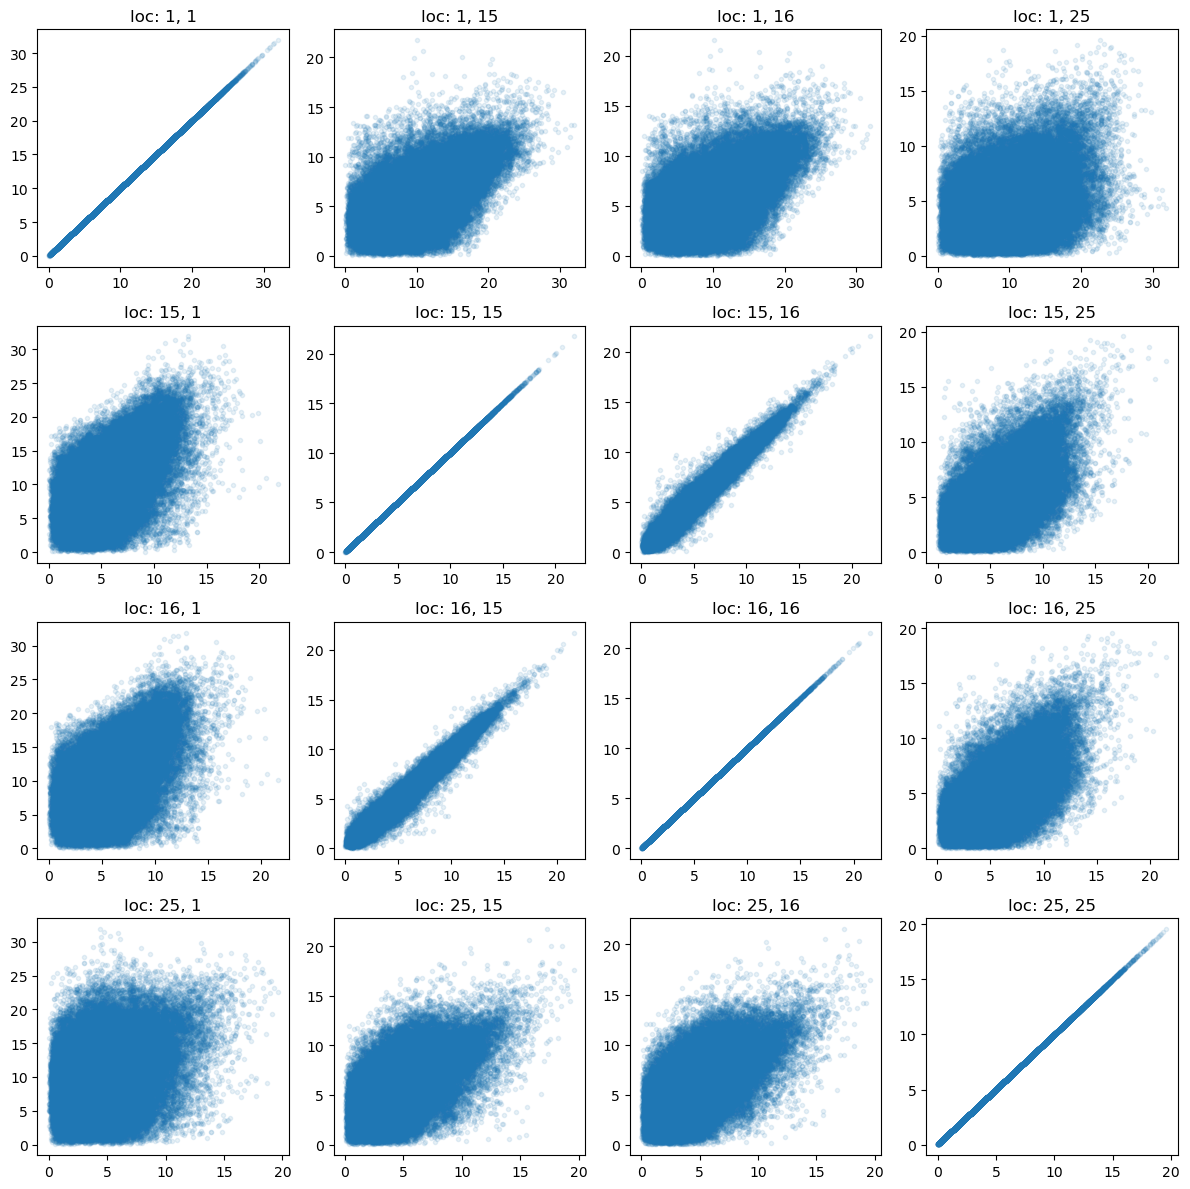

In [14]:
#scatter plot at different locations
fig = plt.figure(figsize=(12,12))
a = 0
for i,k in enumerate(locs):
    for j,l in enumerate(locs):
        ws100_loc1 = ws100[:,k,k]
        ws100_loc2 = ws100[:,l,l]
        a += 1
        ax1 = fig.add_subplot(len(locs), len(locs),a)
        ax1.title.set_text('loc: '+str(k)+', '+str(l))
        plt.plot(ws100_loc1, ws100_loc2, '.', alpha=0.1)
        plt.tight_layout()
plt.tight_layout()
plt.show()

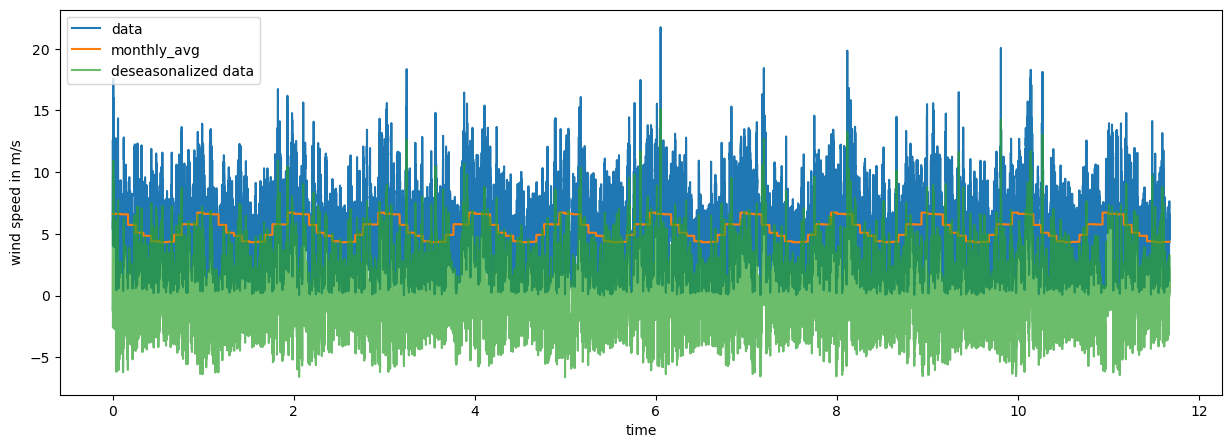

[6.62616753 6.5863154  5.73091782 5.09309923 4.84646715 4.40247402
 4.32675555 4.35896967 4.92321467 5.78445906 5.7626461  6.7251266 ]


In [15]:
ws100_deseasonalized, monthly_params = deseasonalize_data(time=time_frac, data=ws100, loc1=loc1, plot=True)
print(monthly_params)

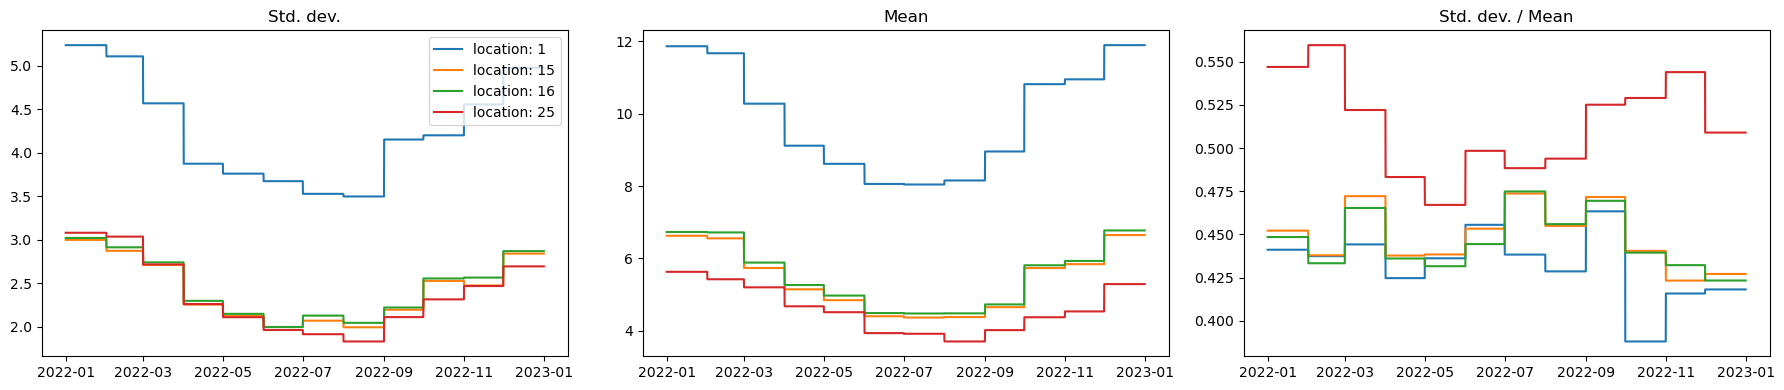

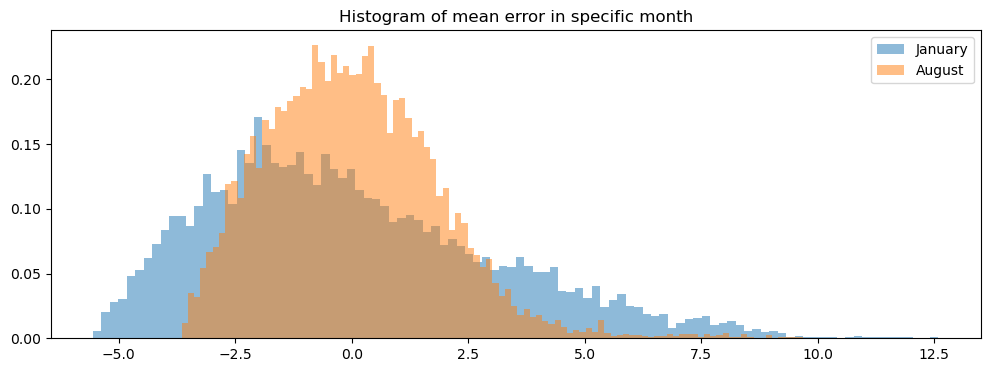

In [16]:
fig, axs = plt.subplots(1,3, figsize=(18,4))
for loc1 in locs:
    df = pd.DataFrame({'time': time, 'value': ws100[:,loc1,loc1], 'mean': ws100[:,loc1,loc1], 'mean_error': ws100[:,loc1,loc1], 'var': ws100[:,loc1,loc1]})
    dfmonth = df['time'].dt.month
    dfyear = df['time'].dt.year
    for i in range(1,13):
        mean = (df[dfmonth == i]['value'].mean())
        var = (df[dfmonth == i]['value'].std())
        df.loc[dfmonth == i,'mean'] = mean
        df.loc[dfmonth == i,'mean_error'] -= mean
        df.loc[dfmonth == i,'var'] = var
    time_plot = df[dfyear==2022]['time']
    axs[0].plot(time_plot, df[dfyear==2022]['var'], label='location: '+str(loc1))
    axs[0].legend(loc="upper right")
    axs[0].set_title('Std. dev.')
    axs[1].plot(time_plot, df[dfyear==2022]['mean'])
    axs[1].set_title('Mean')
    axs[2].plot(time_plot, df[dfyear==2022]['var']/df[dfyear==2022]['mean'])
    axs[2].set_title('Std. dev. / Mean')
    #plt.plot(df['time'], df['var'], label='location: '+str(loc1))
plt.tight_layout()
plt.show()

#last loc only
plt.figure(figsize=(12,4))
plt.hist(df[dfmonth==1]['mean_error'], bins=100, alpha=0.5, density=True, label='January')
plt.hist(df[dfmonth==8]['mean_error'], bins=100, alpha=0.5, density=True, label='August')
plt.legend()
plt.title('Histogram of mean error in specific month')
plt.show()

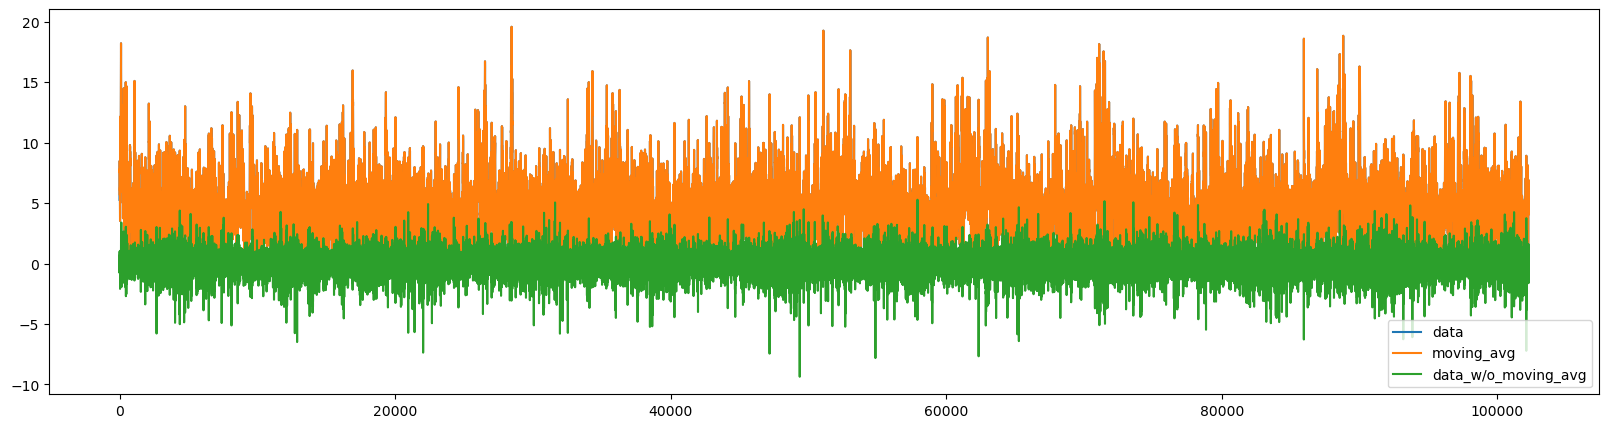

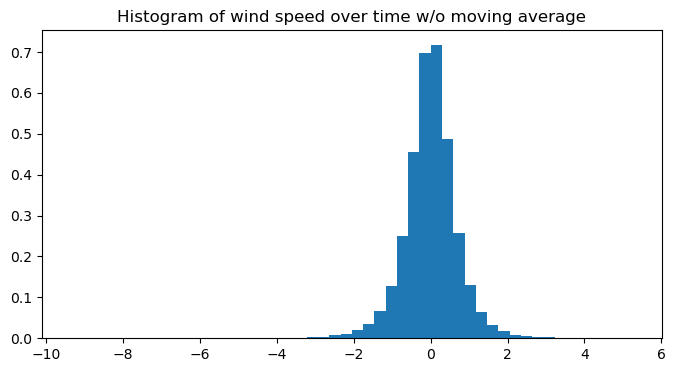

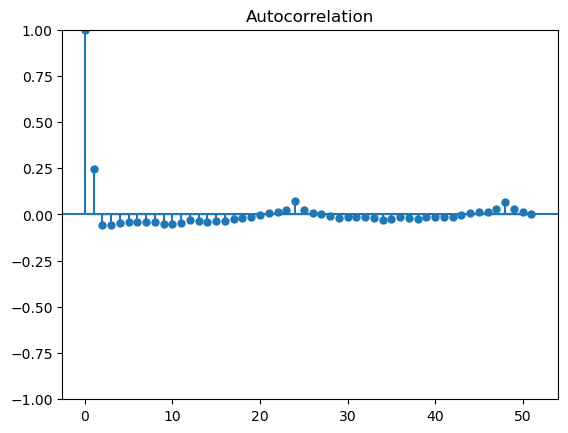

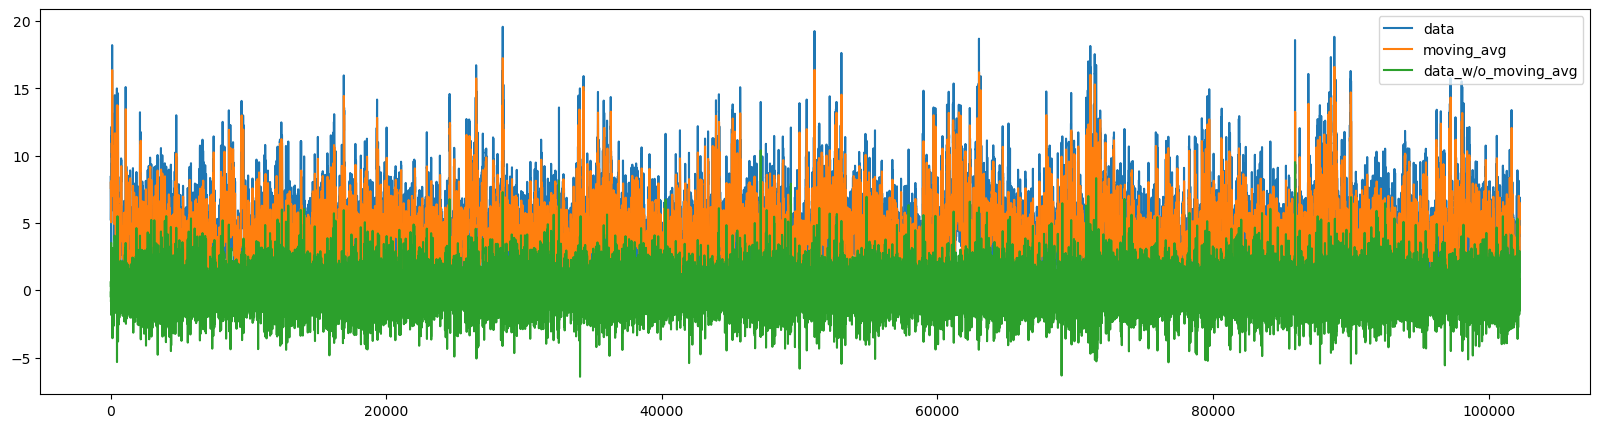

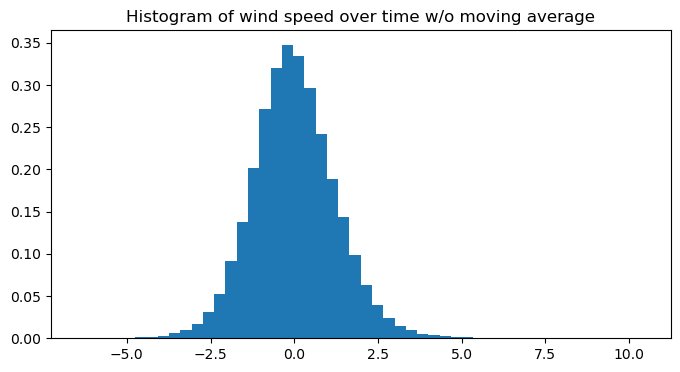

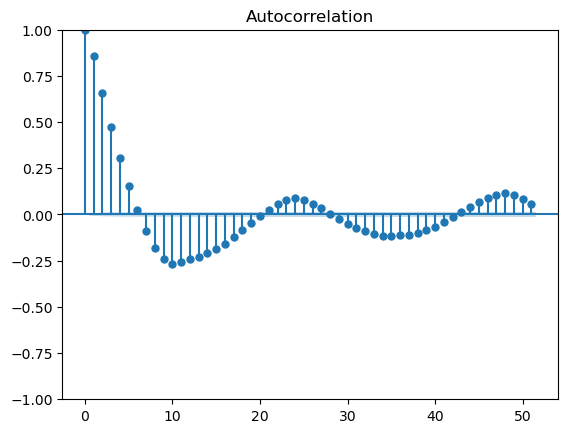

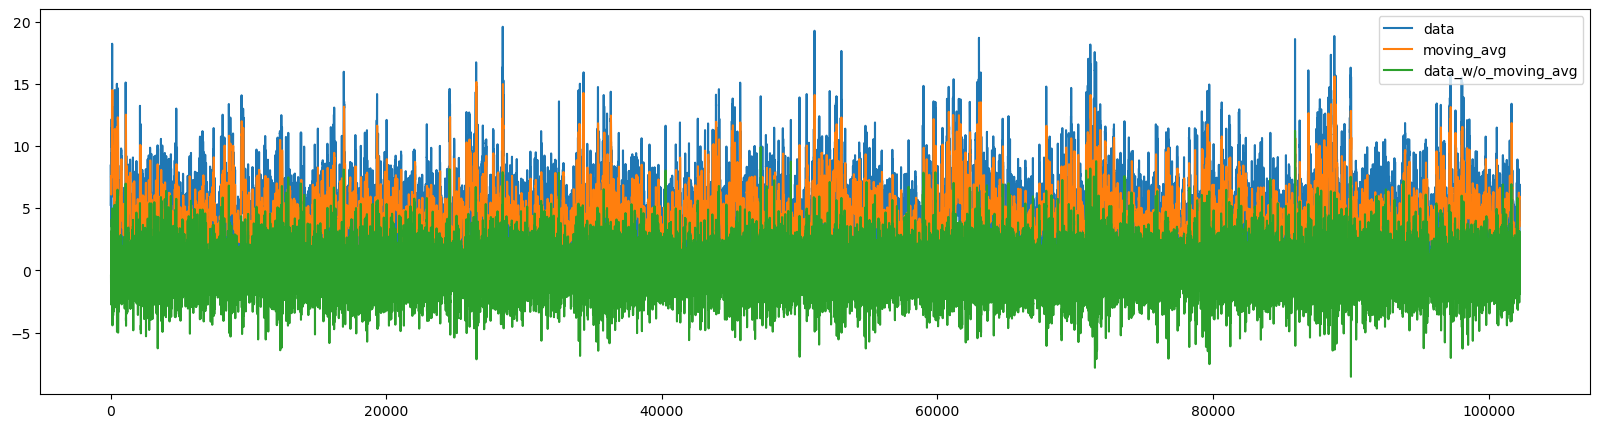

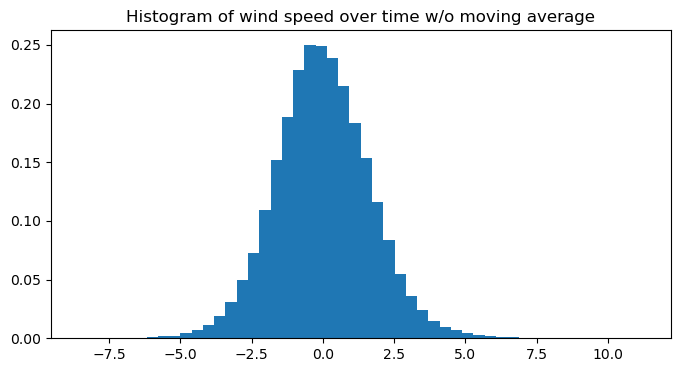

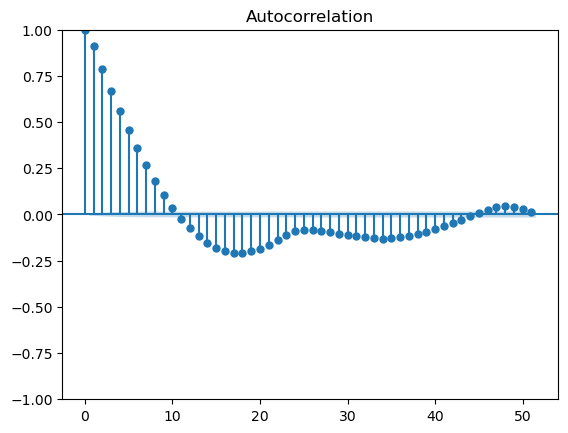

In [17]:
roll_window = [1,12,24]
for i in (roll_window):
    df = pd.DataFrame({'data': ws100[:,loc1,loc1]})
    df['moving_avg'] = df['data'].shift(-1).rolling(i).mean() 
    df['data_w/o_moving_avg'] = df['data']-df['moving_avg']
    df.plot(figsize=(20,5));

    plt.figure(figsize=(8,4))
    plt.hist(df['data_w/o_moving_avg'], density=True, bins=50)
    plt.title('Histogram of wind speed over time w/o moving average')
    plt.show()

    from statsmodels.graphics.tsaplots import plot_acf
    nan_idx = np.argwhere(~np.isnan(df['data_w/o_moving_avg'])).T[0] #11:-1545
    plot_acf(df['data_w/o_moving_avg'][nan_idx]);

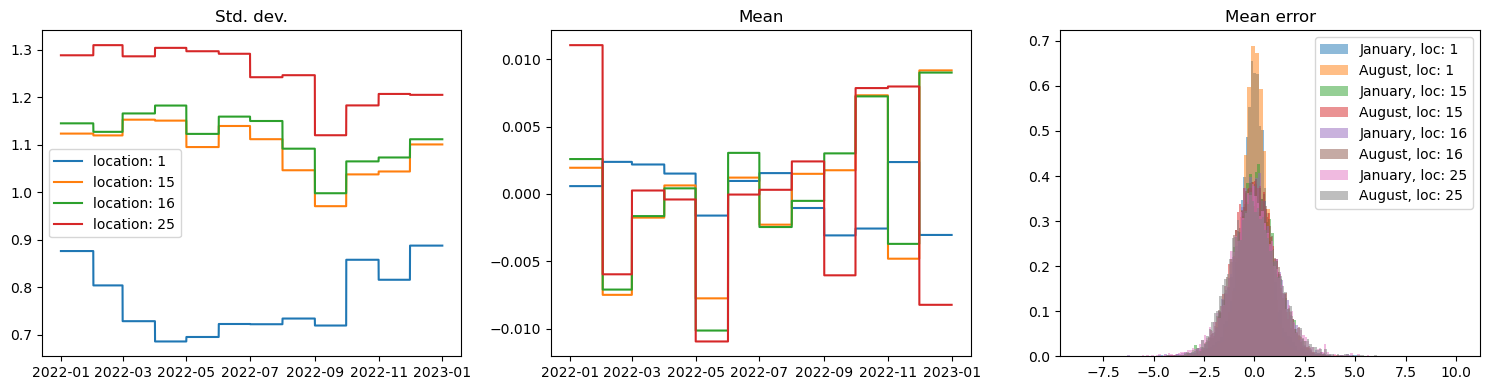

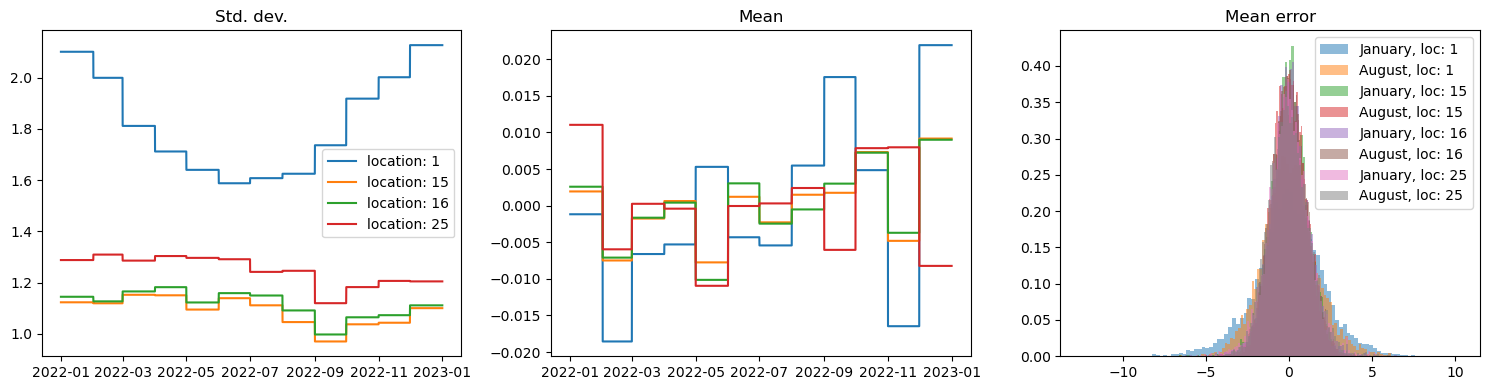

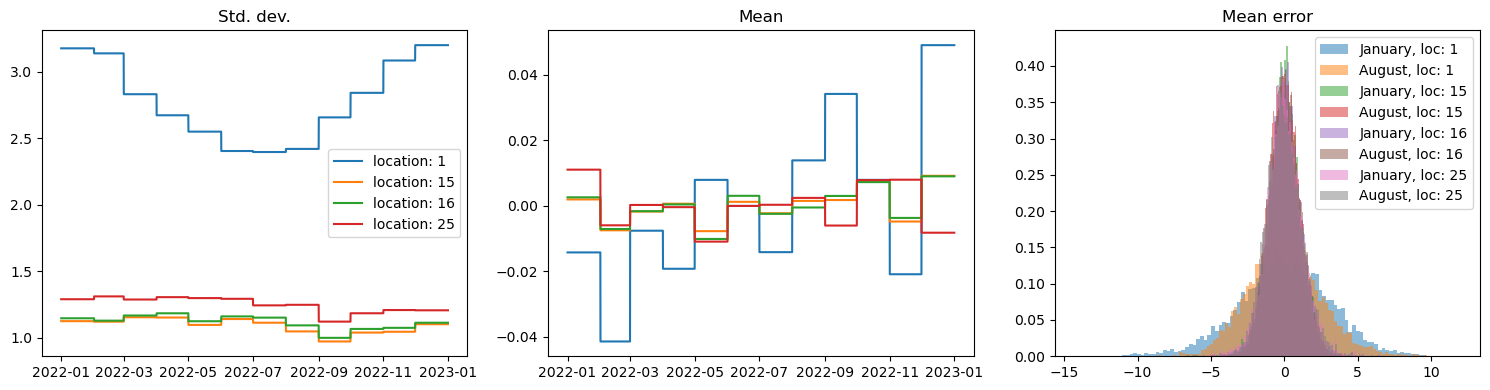

In [18]:
roll_window = [1,12,24]
for i in (roll_window):
    fig, axs = plt.subplots(1,3, figsize=(15,4))

    for loc1 in locs:
        nan_idx = np.argwhere(~np.isnan(ws100[:,loc1,loc1])).T[0]
        df = pd.DataFrame({'data': ws100[nan_idx,loc1,loc1]})
        df['moving_avg'] = df['data'].shift(-1).rolling(i).mean() #6,12,24h
        df['data_w/o_moving_avg'] = df['data']-df['moving_avg']
        
        df = pd.DataFrame({'time': time[nan_idx], 'value': df['data_w/o_moving_avg'], 'mean': df['data_w/o_moving_avg'], 'mean_error': df['data_w/o_moving_avg'], 'var': df['data_w/o_moving_avg']})
        dfmonth = df['time'].dt.month
        dfyear = df['time'].dt.year
        for i in range(1,13):
            mean = (df[dfmonth == i]['value'].mean())
            var = (df[dfmonth == i]['value'].std())
            df.loc[dfmonth == i,'mean'] = mean
            df.loc[dfmonth == i,'mean_error'] -= mean
            df.loc[dfmonth == i,'var'] = var
        time_plot = df[dfyear==2022]['time']
        axs[0].plot(time_plot, df[dfyear==2022]['var'], label='location: '+str(loc1))
        axs[0].legend()
        axs[0].set_title('Std. dev.')
        axs[1].plot(time_plot, df[dfyear==2022]['mean'])
        axs[1].set_title('Mean')
        axs[2].hist(df[dfmonth==1]['mean_error'], bins=100, alpha=0.5, density=True, label='January, loc: '+str(loc1))
        axs[2].hist(df[dfmonth==8]['mean_error'], bins=100, alpha=0.5, density=True, label='August, loc: '+str(loc1))
        axs[2].legend()
        axs[2].set_title('Mean error')
    plt.tight_layout()
    plt.show()

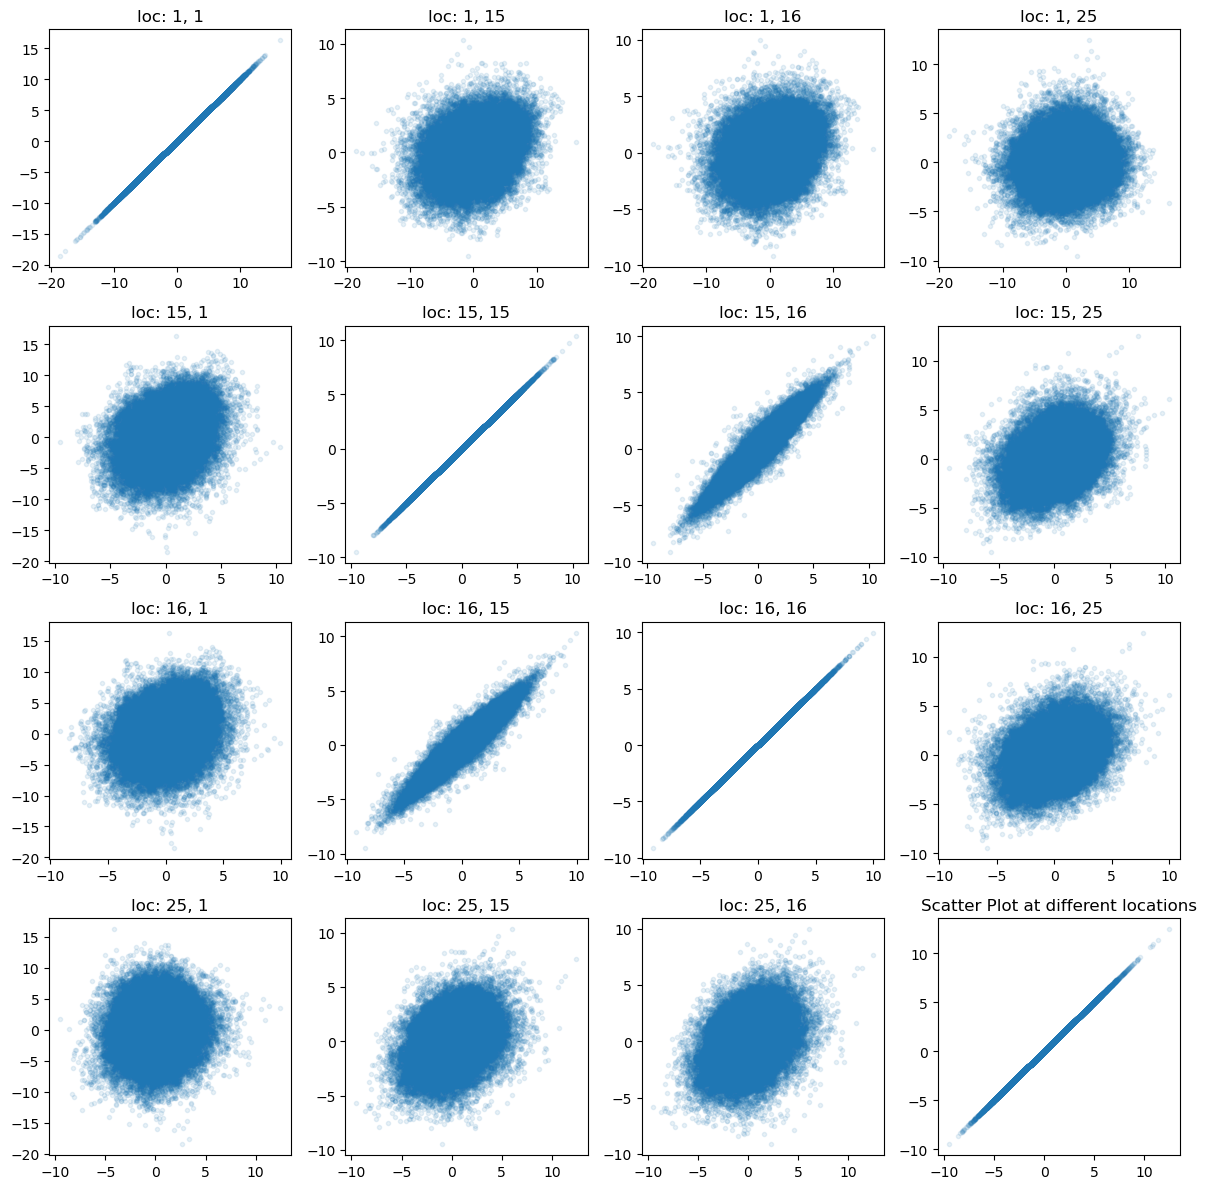

In [19]:
fig = plt.figure(figsize=(12,12))
a = 0
for i,k in enumerate(locs):
    for j,l in enumerate(locs):
        df_loc1 = pd.DataFrame({'data': ws100[:,k,k]})
        df_loc2 = pd.DataFrame({'data': ws100[:,l,l]})
        df_loc1['moving_avg'] = df_loc1['data'].shift(1).rolling(window=24).mean() 
        df_loc1['data_w/o_moving_avg'] = df_loc1['data']-df_loc1['moving_avg']
        df_loc2['moving_avg'] = df_loc2['data'].shift(1).rolling(window=24).mean() 
        df_loc2['data_w/o_moving_avg'] = df_loc2['data']-df_loc2['moving_avg']
        a += 1
        ax1 = fig.add_subplot(len(locs), len(locs),a)
        ax1.title.set_text('loc: '+str(k)+', '+str(l))
        plt.plot(df_loc1['data_w/o_moving_avg'], df_loc2['data_w/o_moving_avg'], '.', alpha=0.1)
        plt.tight_layout()
plt.title('Scatter Plot at different locations')
plt.show()

In [ ]:
# by hours
if False:
    ws100_deseasonalized, monthly_params = deseasonalize_data(time=time_frac, data=ws100, loc1=loc1)
    time_nan = time[np.argwhere(~np.isnan(ws100[:,loc1,loc1])).T[0] ]

    df = pd.DataFrame({'time': time_nan, 'value': ws100_deseasonalized, 'mean': ws100_deseasonalized, 'mean_error': ws100_deseasonalized, 'var': ws100_deseasonalized})
    df2 = pd.DataFrame({'time': time, 'value': ws100[:,loc1,loc1], 'mean': ws100[:,loc1,loc1], 'mean_error': ws100[:,loc1,loc1], 'var': ws100[:,loc1,loc1]})

    dfhour = df['time'].dt.hour
    df2hour = df2['time'].dt.hour

    for i in range(np.unique(dfhour)[-1]+1):
        mean = (df[dfhour == i]['value'].mean())
        mean2 = (df2[df2hour == i]['value'].mean())
        var = (df[dfhour == i]['value'].std())
        var2 = (df2[df2hour == i]['value'].std())
        df.loc[dfhour == i,'mean'] = mean
        df.loc[dfhour == i,'mean_error'] -= mean
        df.loc[dfhour == i,'var'] = var
        df2.loc[df2hour == i,'mean'] = mean2
        df2.loc[df2hour == i,'mean_error'] -= mean2
        df2.loc[df2hour == i,'var'] = var2

    sel_day = df.loc[(df['time']>='1/1/22') & (df['time']<'1/2/22')]
    sel_day2 = df2.loc[(df2['time']>='1/1/22') & (df2['time']<'1/2/22')]

    plt.figure(figsize=(12,4))
    plt.plot(sel_day['time'].dt.hour, sel_day['var'], 'o-', label='std_deseasonalized')
    plt.plot(sel_day2['time'].dt.hour, sel_day2['var'], 'x-', label='std')
    plt.xlabel('time')
    plt.legend()
    plt.show()

    fig,ax1 = plt.subplots(figsize=(12,4))
    ax1.plot(sel_day['time'].dt.hour, sel_day['mean'], 'o-', color='tab:blue', label='mean_deseasonalized')
    ax1.set_ylabel('mean_deseasonalized', color = 'tab:blue') 
    ax1.set_xlabel('time')
    ax2 = ax1.twinx() 
    ax2.plot(sel_day2['time'].dt.hour, sel_day2['mean'], 'x-', color='tab:orange', label='mean')
    ax2.set_ylabel('mean', color = 'tab:orange') 
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.hist(df[dfhour==4]['mean_error'], bins=100, alpha=0.5, density=True, label='4 o\'clock')
    plt.hist(df[dfhour==9]['mean_error'], bins=100, alpha=0.5, density=True, label='9 o\'clock')
    plt.hist(df[dfhour==10]['mean_error'], bins=100, alpha=0.5, density=True, label='10 o\'clock')
    plt.legend()
    plt.title('Histogram of mean error at specific hour')
    plt.show()

# day/night
if False:
    ws100_deseasonalized, monthly_params = deseasonalize_data(time=time_frac, data=ws100, loc1=loc1)
    time_nan = time[np.argwhere(~np.isnan(ws100[:,loc1,loc1])).T[0] ]

    df = pd.DataFrame({'time': time_nan, 'value': ws100_deseasonalized, 'mean': ws100_deseasonalized, 'mean_error': ws100_deseasonalized, 'var': ws100_deseasonalized})

    dfhour10_16 = df[(df['time'].dt.hour >= 10) & (df['time'].dt.hour <= 16)]['time'].dt.hour

    df_1016_idx = df.loc[df.index.isin(dfhour10_16.index)] #df.iloc[dfhour10_16.index]
    df_else_idx = df.loc[~df.index.isin(dfhour10_16.index)]

    #for 10-14h & rest
    mean = df_1016_idx['value'].mean()
    mean2 = df_else_idx['value'].mean()
    var = df_1016_idx['value'].std()
    var2 = df_else_idx['value'].std()
    df.loc[dfhour10_16.index,'mean'] = mean
    df.loc[~df.index.isin(dfhour10_16.index),'mean'] = mean2
    df.loc[dfhour10_16.index,'mean_error'] -= mean
    df.loc[~df.index.isin(dfhour10_16.index),'mean_error'] -= mean2
    df.loc[dfhour10_16.index,'var'] = var
    df.loc[~df.index.isin(dfhour10_16.index),'var'] = var2

    fig,ax1 = plt.subplots(figsize=(12,4))
    sel_day = df.loc[(df['time']>='1/1/22') & (df['time']<'1/2/22')]
    ax1.plot(sel_day['time'].dt.hour, sel_day['mean'], 'o-', color='tab:blue', label='mean')
    ax1.set_ylabel('mean', color = 'tab:blue') 
    ax1.set_xlabel('time')
    ax2 = ax1.twinx() 
    ax2.plot(sel_day['time'].dt.hour, sel_day['var'], 'x-', color='tab:orange', label='var')
    ax2.set_ylabel('var', color = 'tab:orange') 
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.hist(df.loc[dfhour10_16.index,'mean_error'], bins=100, alpha=0.5, density=True, label='10-16h')
    plt.hist(df.loc[~df.index.isin(dfhour10_16.index),'mean_error'], bins=100, alpha=0.5, density=True, label='16-10h')
    plt.legend()
    plt.title('Histogram of mean error at specific times')
    plt.show()

### Principal Component Analysis

In [7]:
from sklearn.decomposition import PCA

nan_idx = np.argwhere(~np.isnan(ws100[:,0,0])).T[0] #11:-1545
time_nan = time[nan_idx]
Y = ws100[nan_idx,:,:]
X = Y.reshape(Y.shape[0], -1)

In [12]:
pca = PCA(n_components=10)
X_red = pca.fit_transform(X) #shape (time, n_components)

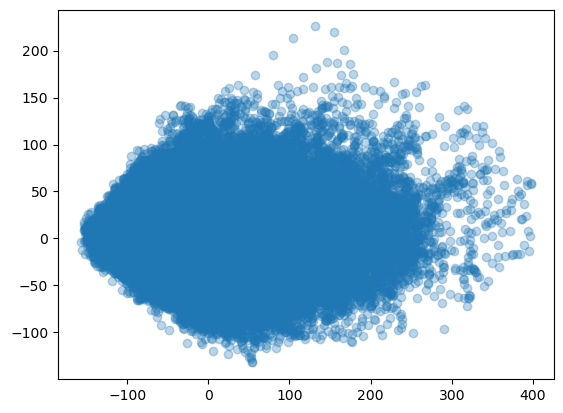

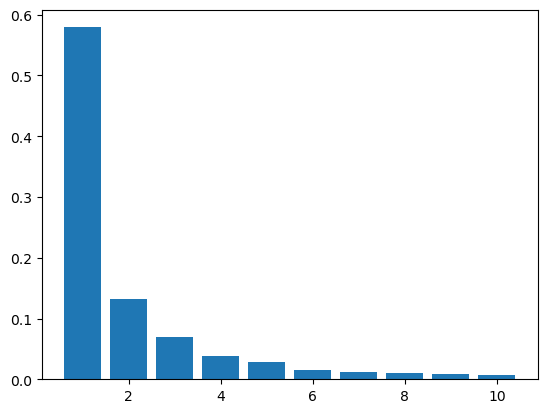

In [15]:
plt.figure()
plt.scatter(X_red[:, 0], X_red[:, 1], alpha=0.3, label="samples")
plt.show()

plt.figure()
plt.bar(np.linspace(1,pca.n_components_,pca.n_components_), pca.explained_variance_ratio_)
plt.show()
#np.cumsum(pca.explained_variance_ratio_)

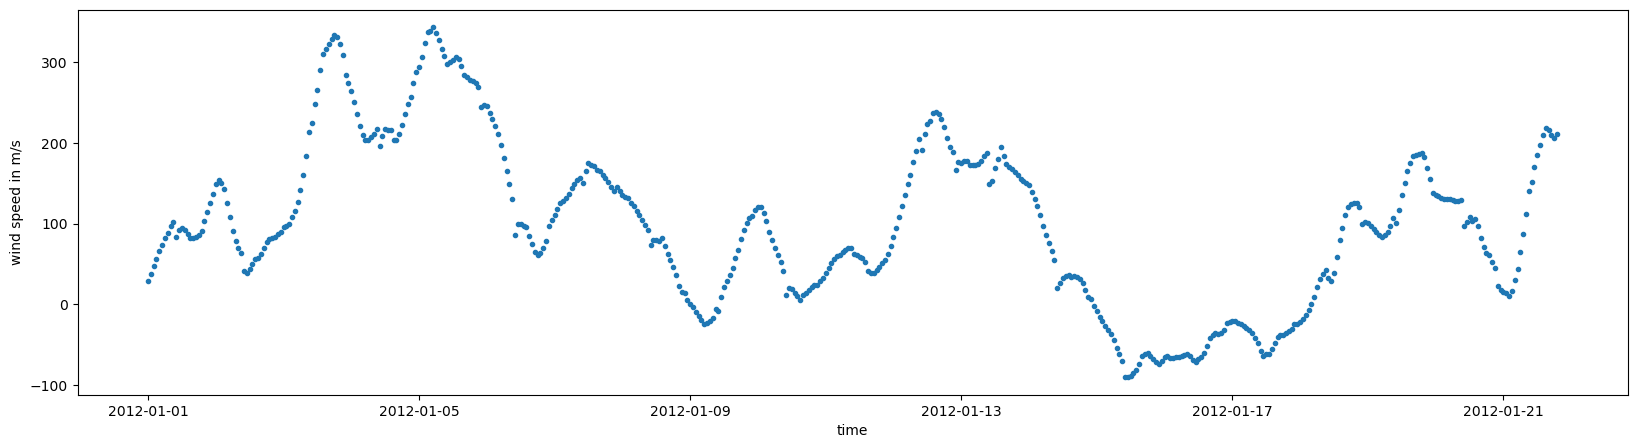

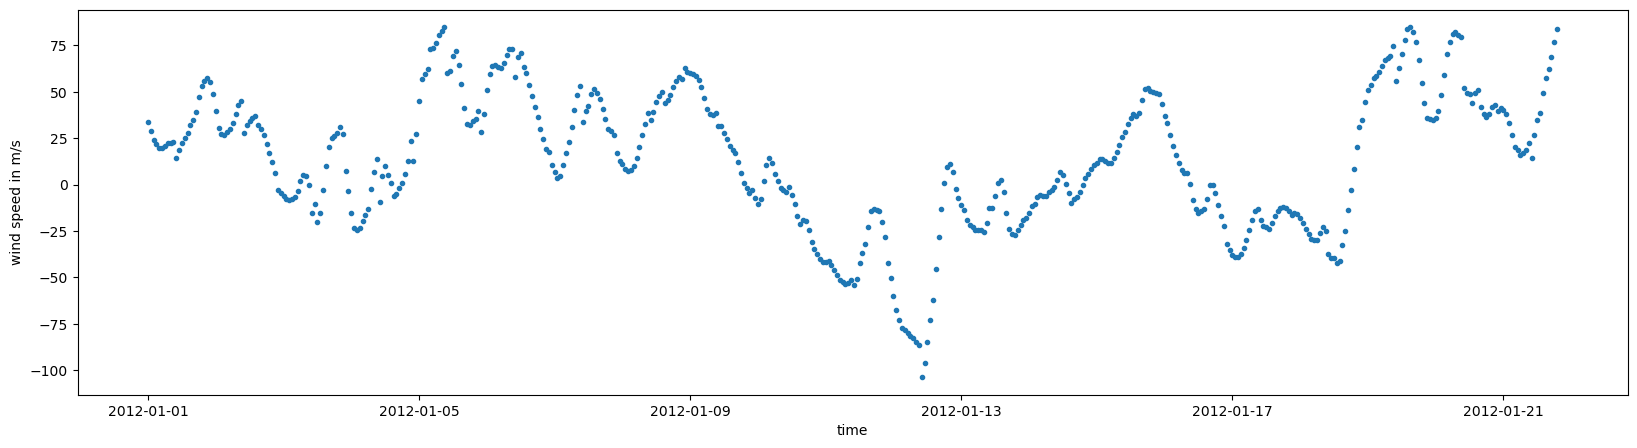

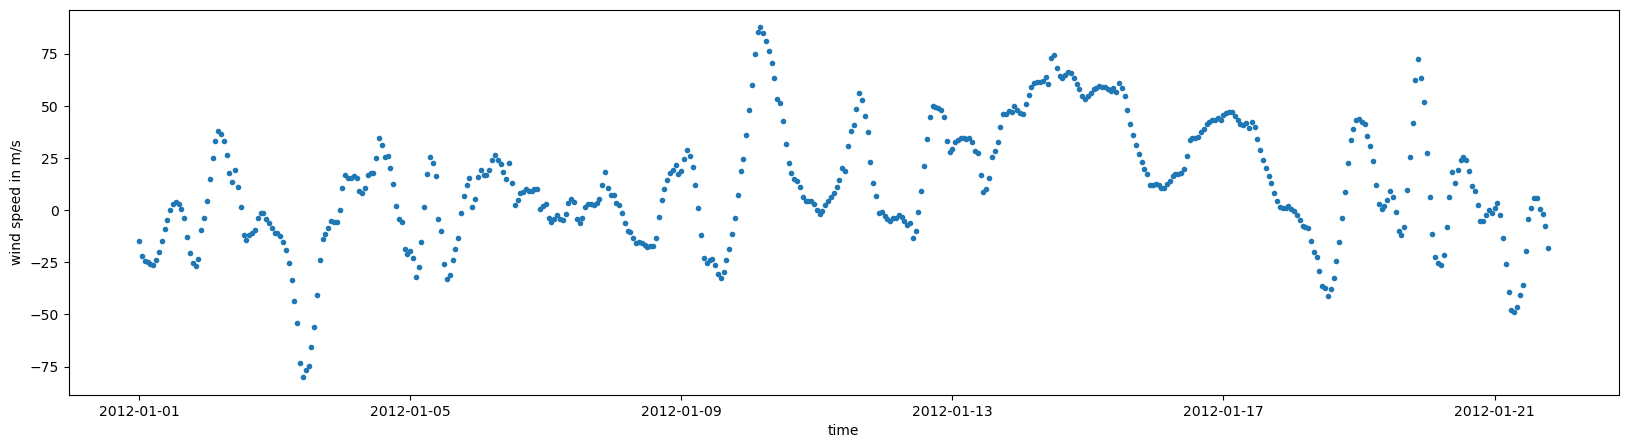

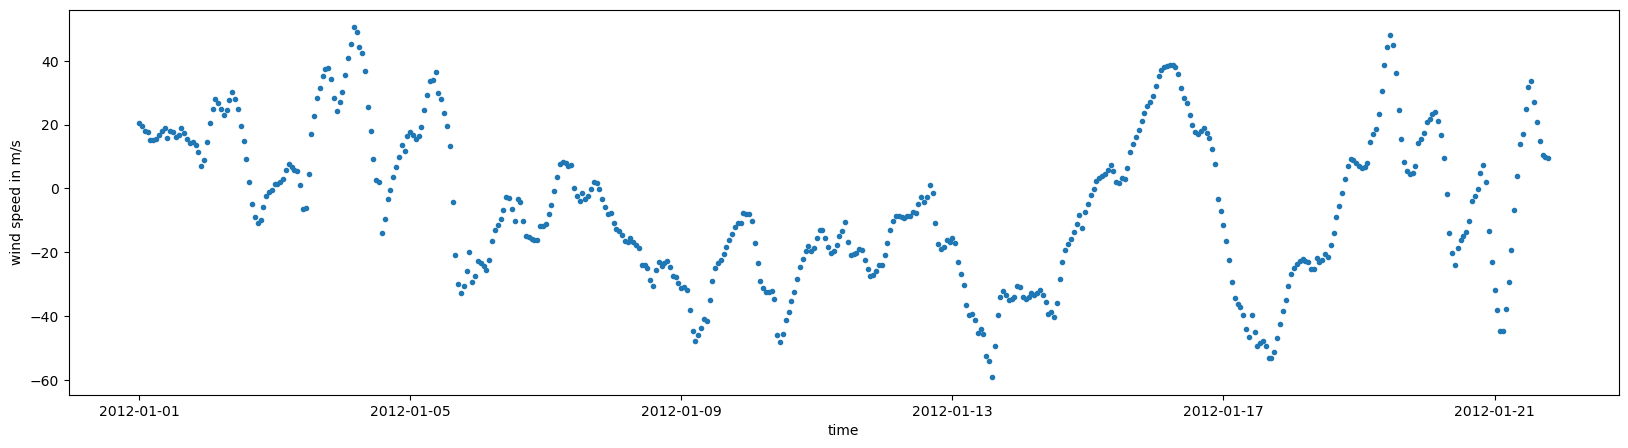

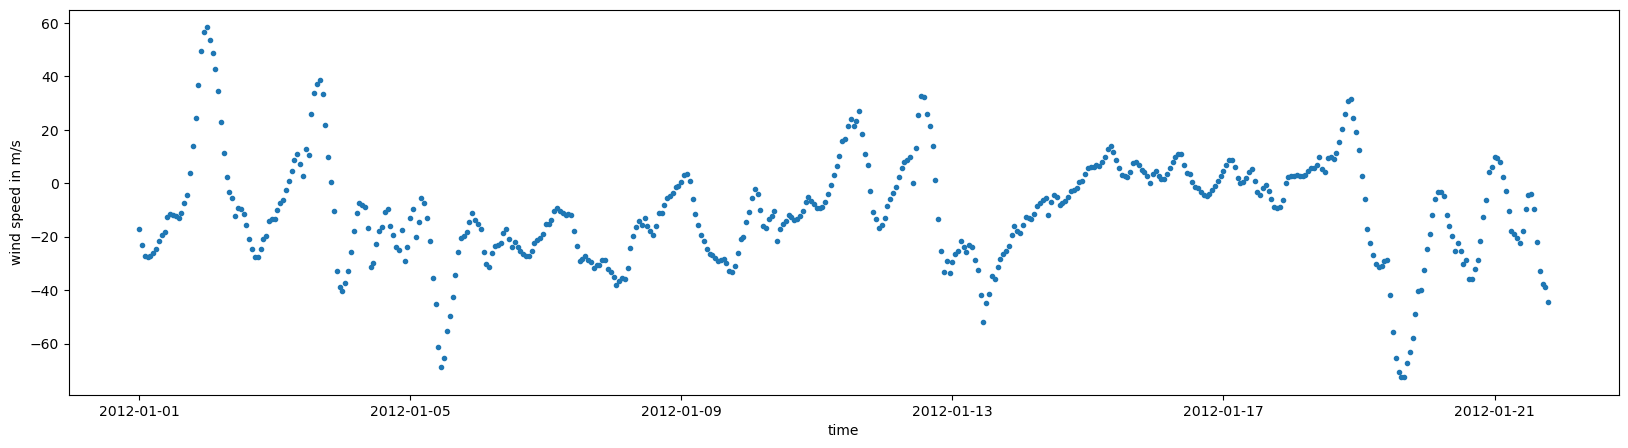

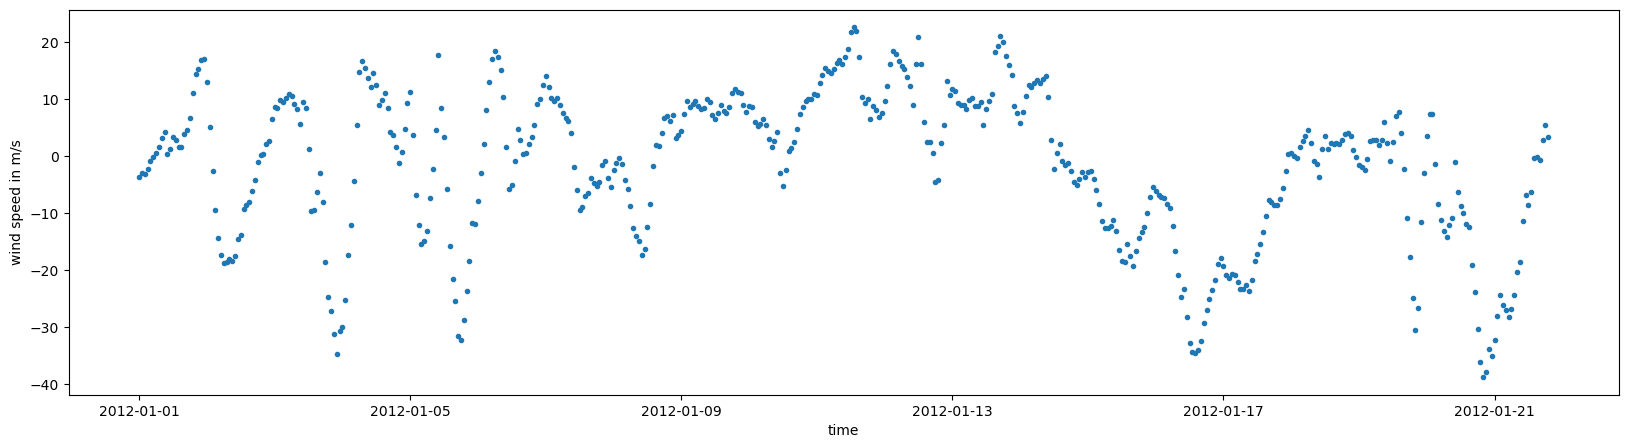

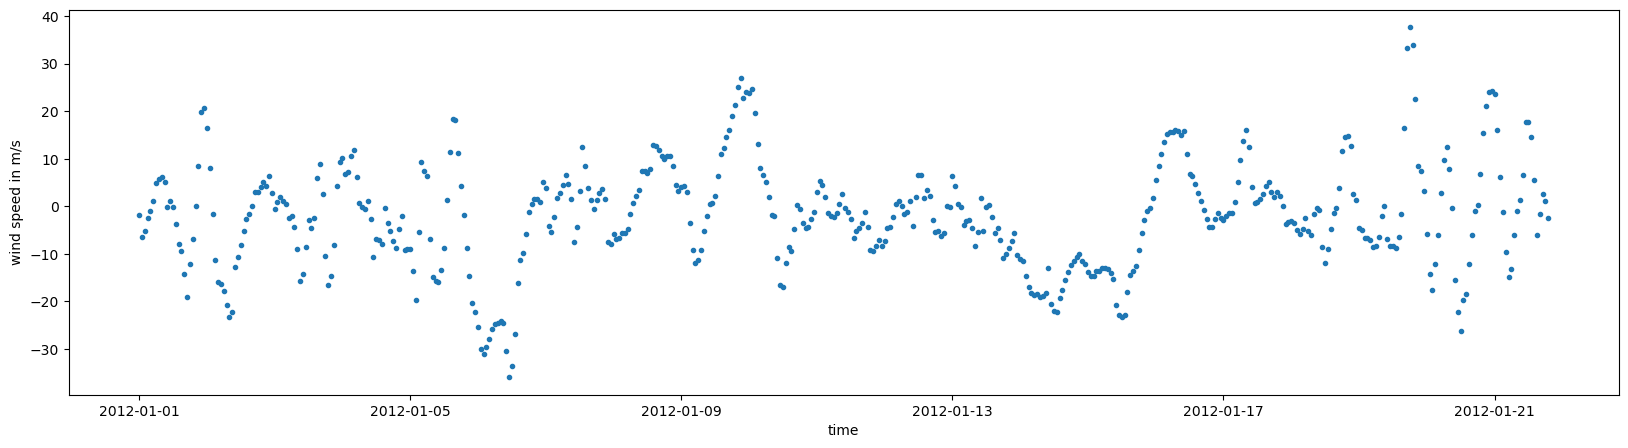

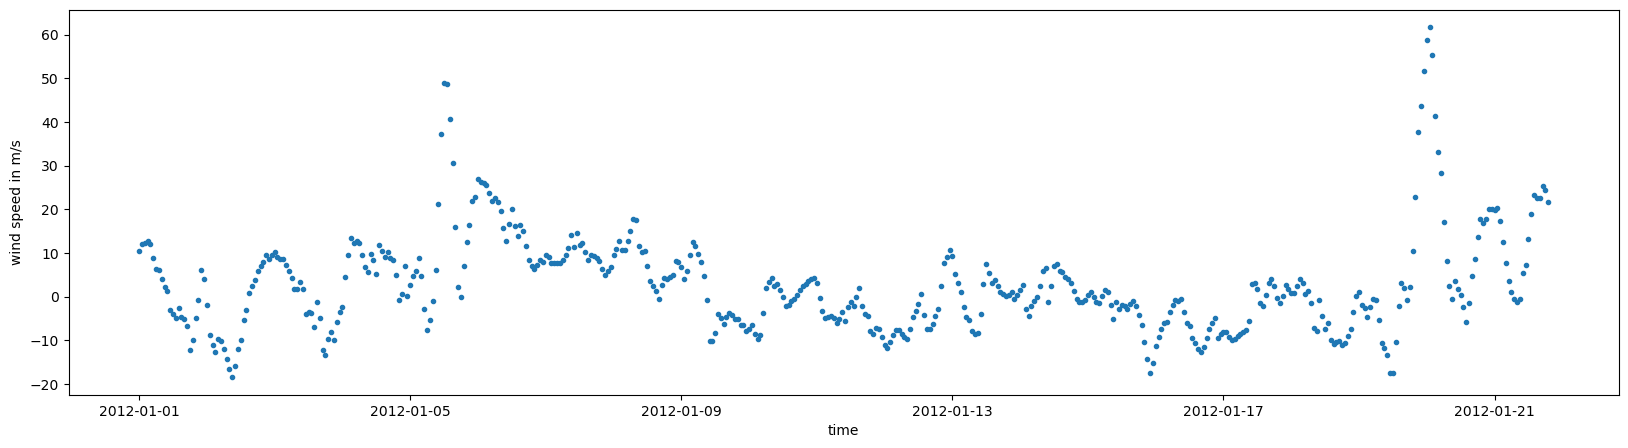

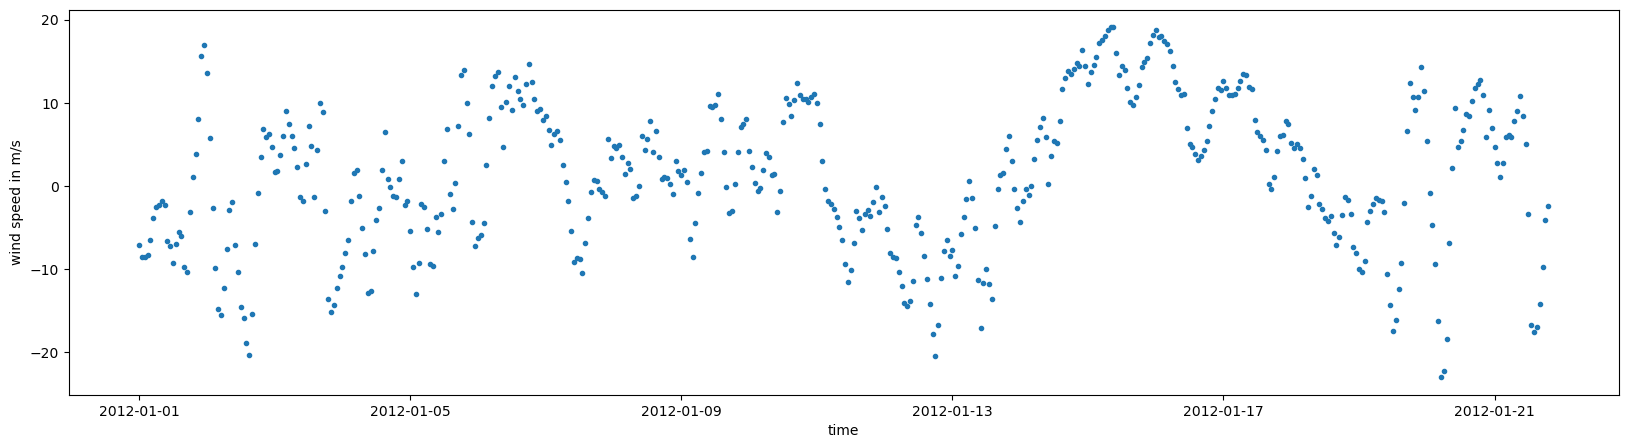

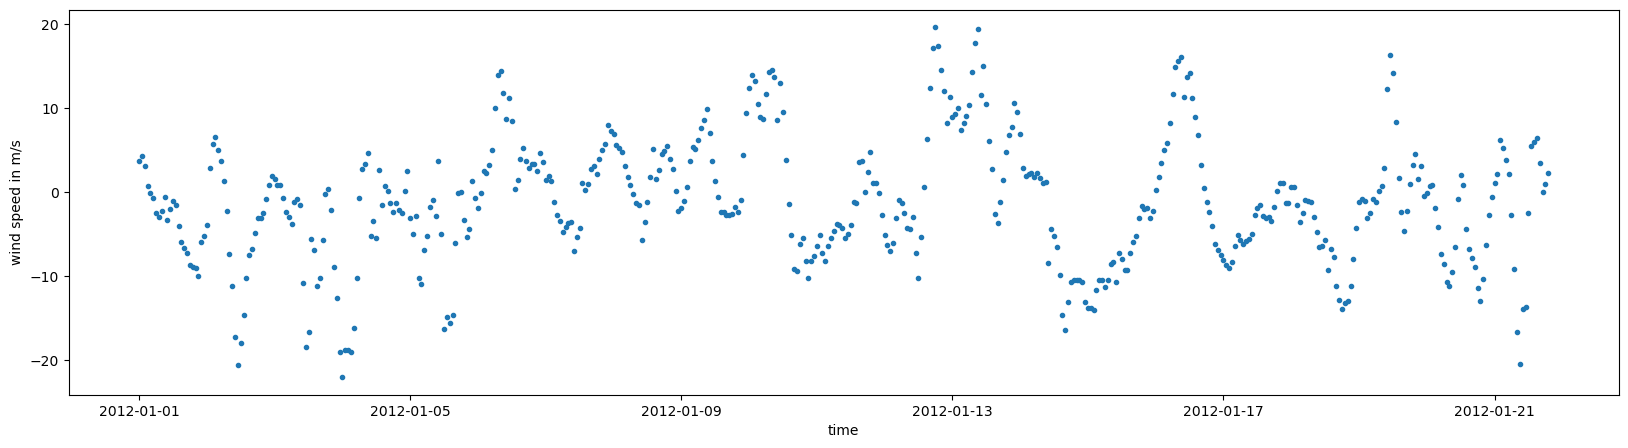

In [25]:
#components over time
for loc0 in range(X_red.shape[1]):
    plt.figure(figsize=(20,5))
    plt.plot(time_nan[:500],X_red[:500,loc0], '.')
    plt.ylabel('wind speed in m/s')
    plt.xlabel('time')
    plt.show()

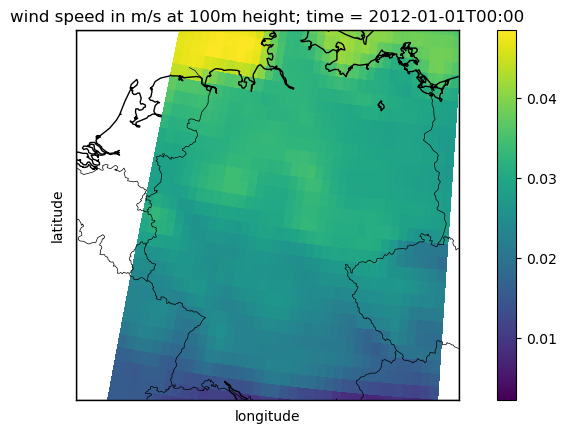

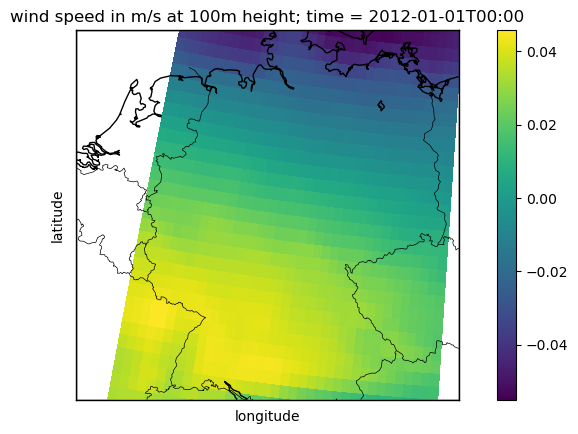

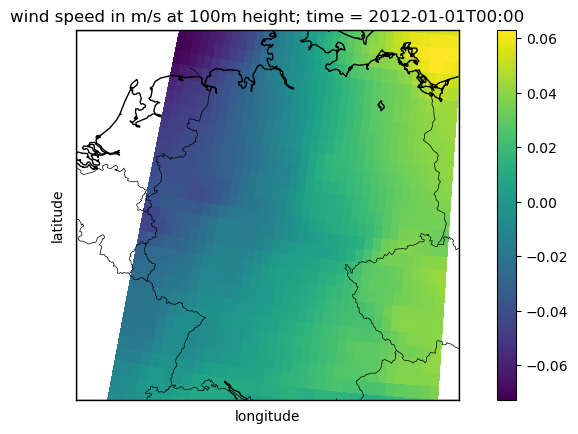

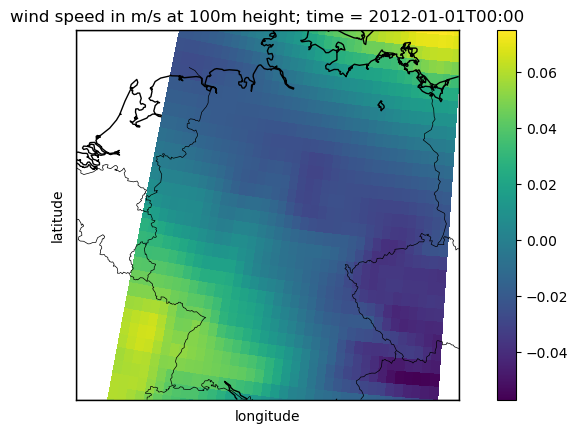

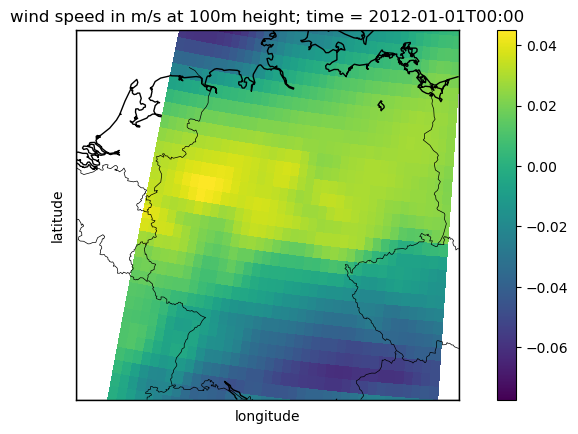

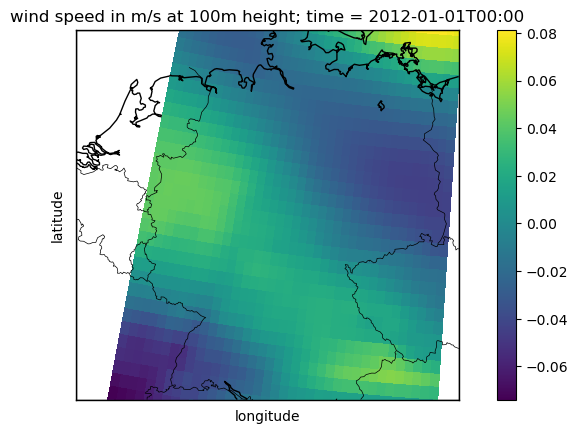

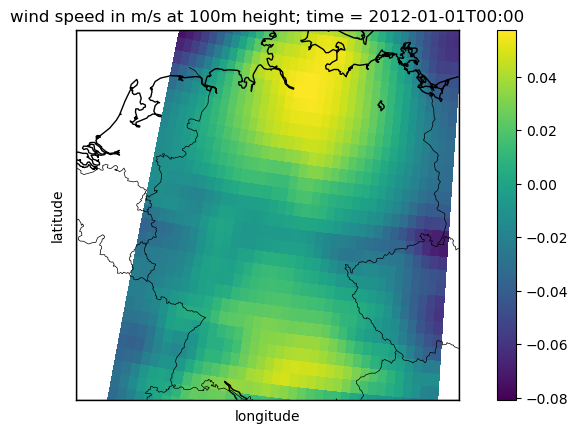

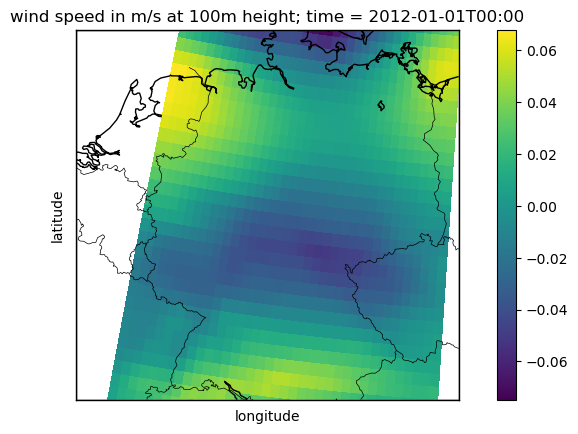

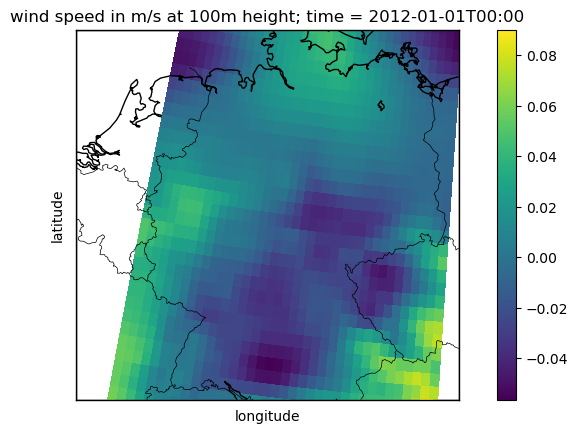

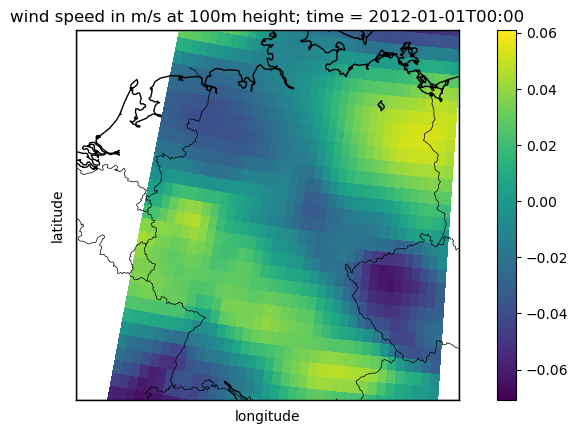

In [10]:
#basis functions on map
components_loc = pca.components_.reshape(pca.n_components_, ws100.shape[1], ws100.shape[2]) #(n_components, 1221)->(n_components, 33, 37)

lon, lat = np.meshgrid(lons, lats)

for i in range(pca.n_components_):
    m = Basemap(llcrnrlon=5,llcrnrlat=47,urcrnrlon=15,urcrnrlat=55,
             resolution='i', projection='tmerc', lat_0 = 80, lon_0 = 20)
    xi, yi = m(lon, lat)
    cs = m.pcolor(xi,yi,np.squeeze(components_loc[i])) #ws100[0,:,:]
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()
    cbar = m.colorbar(cs, location='right', pad="10%")
    tt = np.array(time[0], dtype='datetime64[m]') #10 & 4378
    plt.title('wind speed in m/s at 100m height; time = '+str(tt))
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.show()

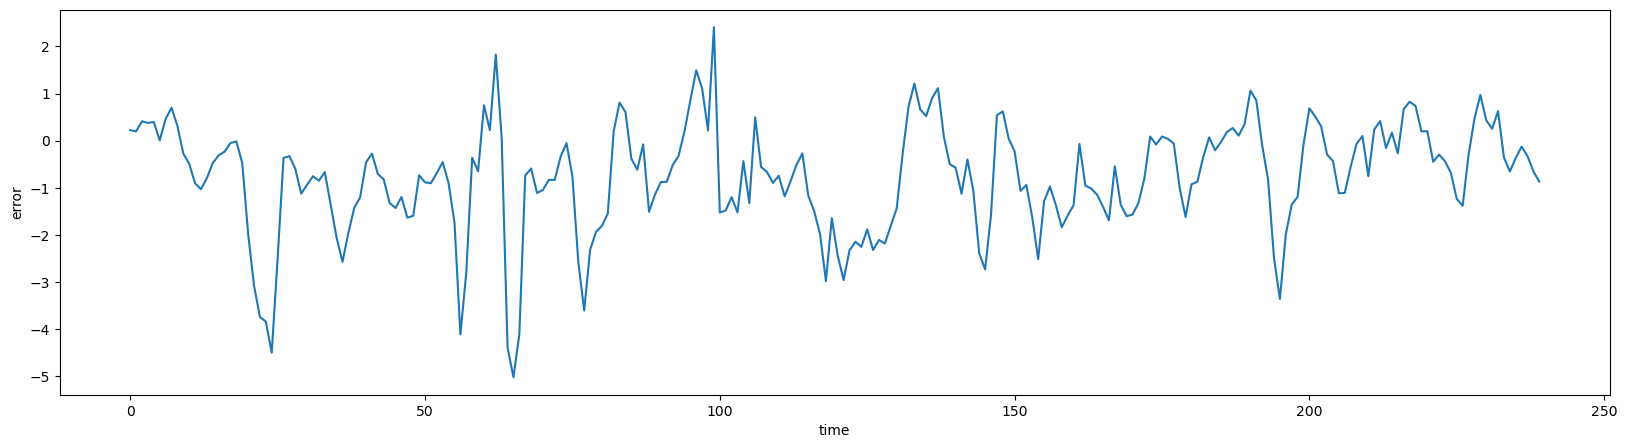

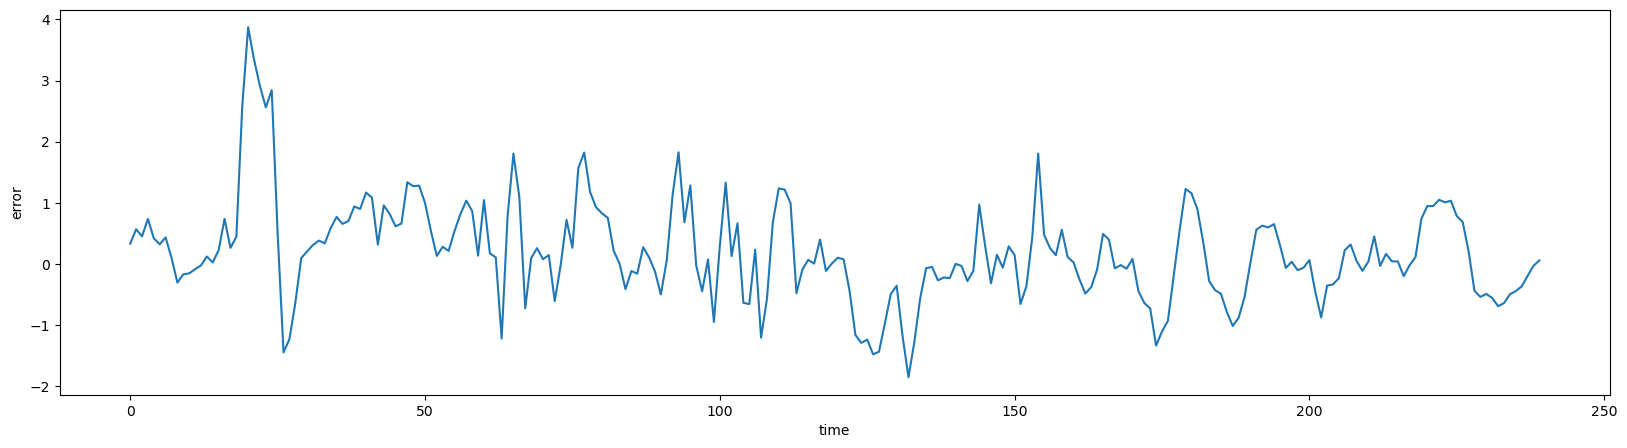

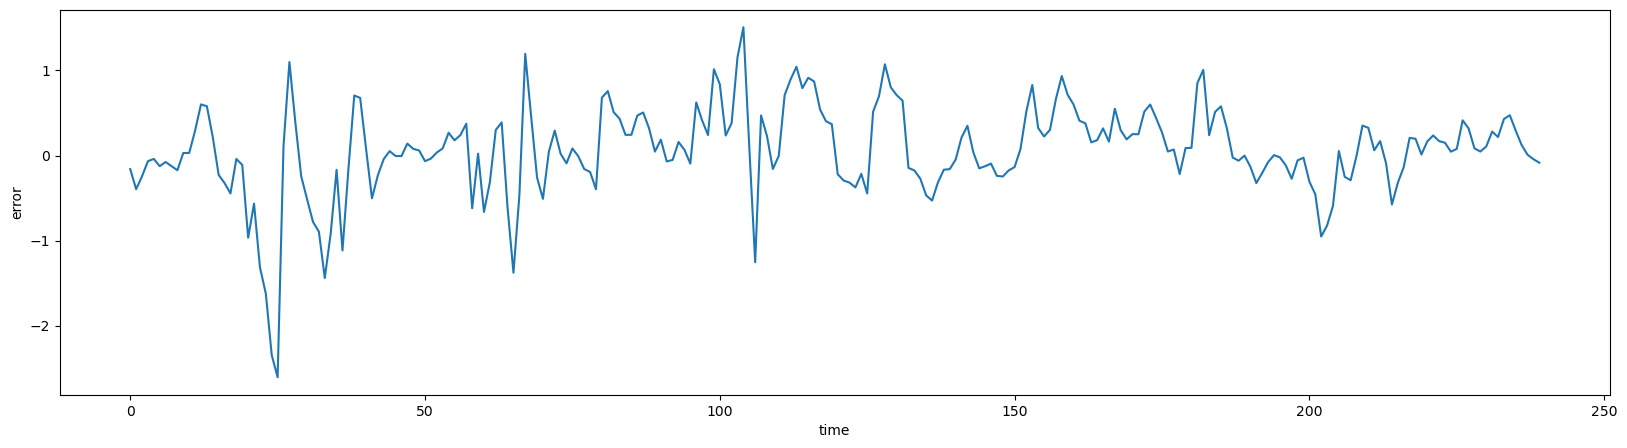

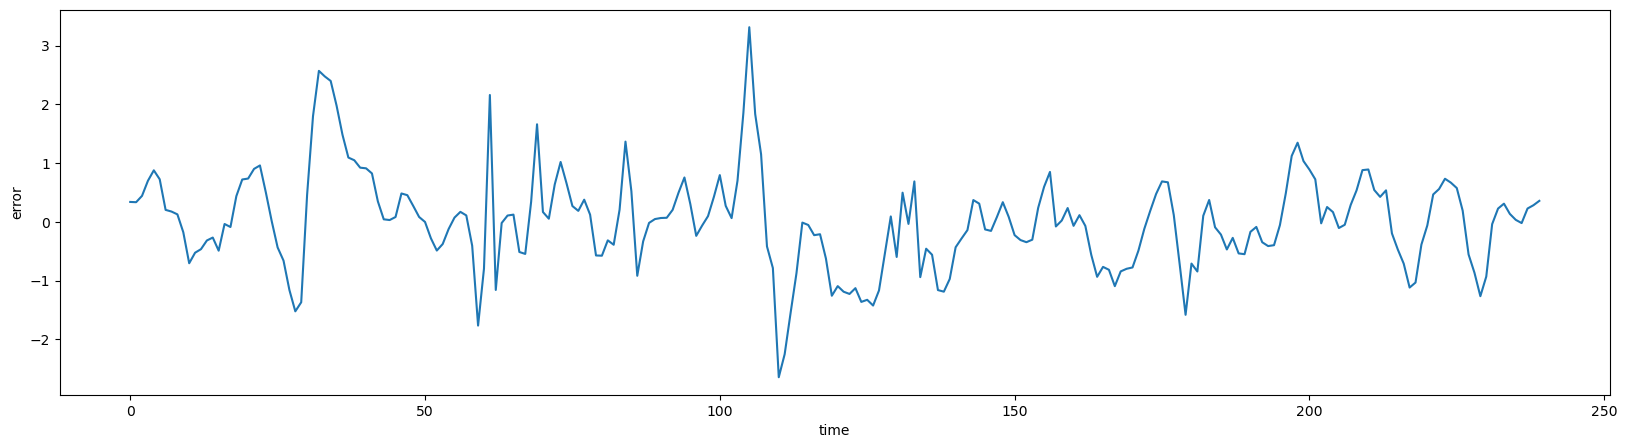

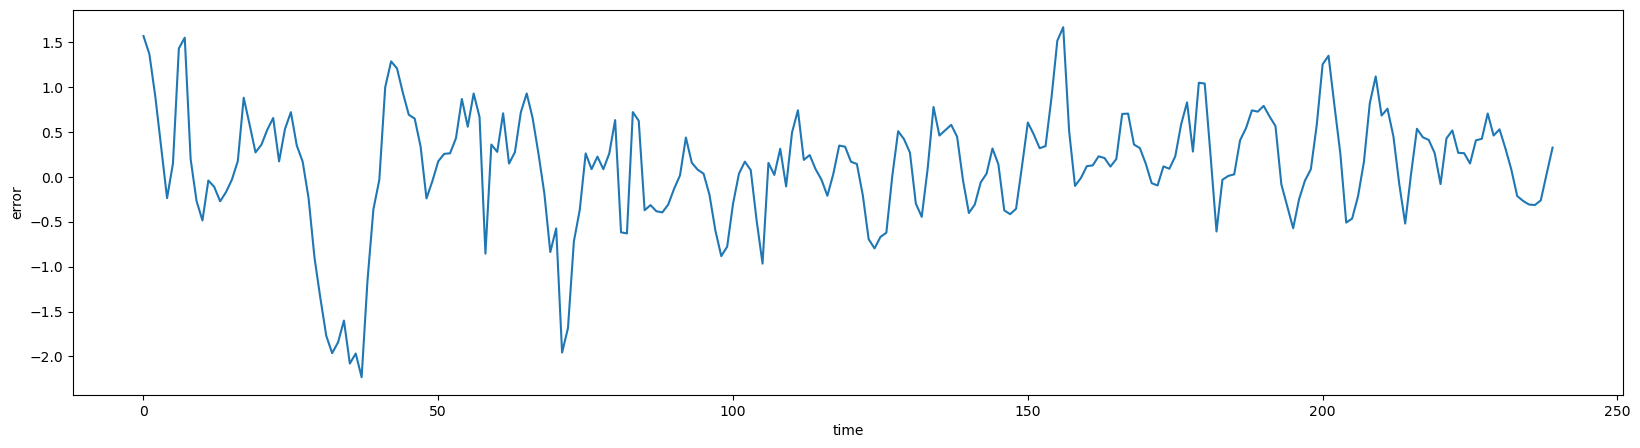

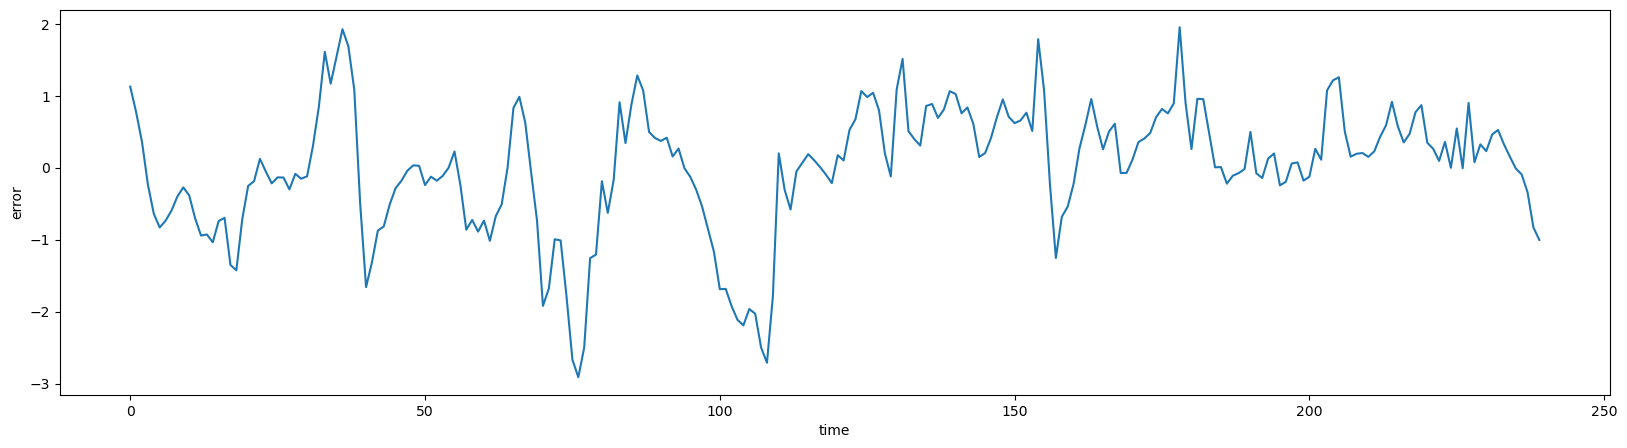

In [11]:
# error plot for specific point
for loc0 in range(0,30,5):
    true_val = ws100[nan_idx,loc0,loc0]
    approx_val = pca.inverse_transform(X_red).reshape(Y.shape)[:,loc0,loc0]
    error = (approx_val - true_val)[0:240]
    plt.figure(figsize=(20,5))
    plt.plot(error)
    plt.ylabel('error')
    plt.xlabel('time')
    plt.show()

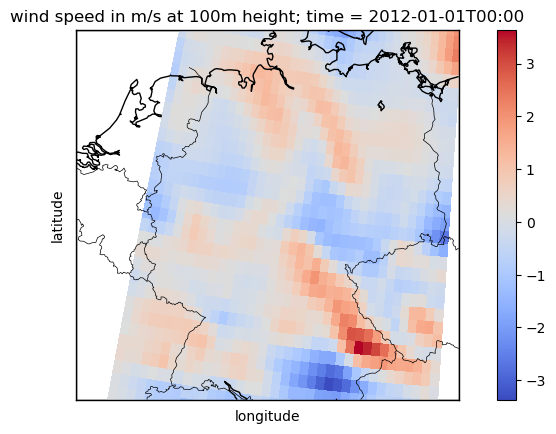

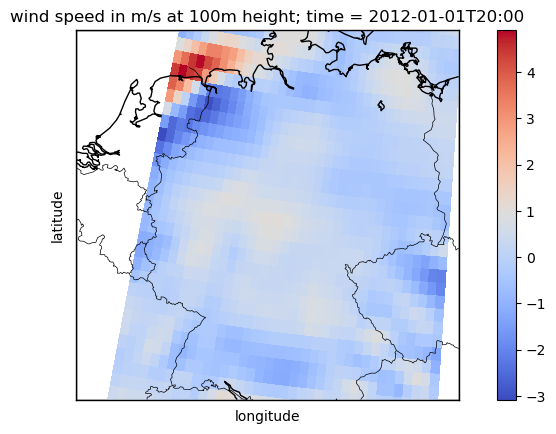

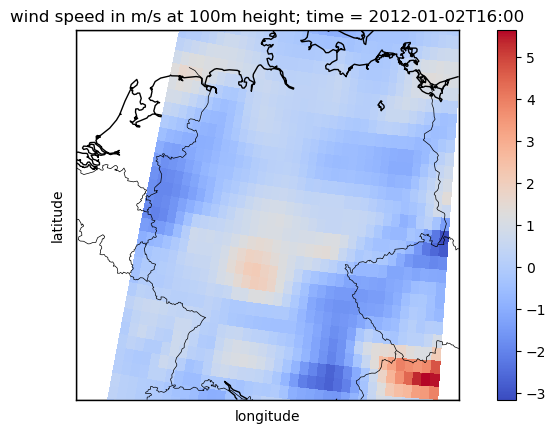

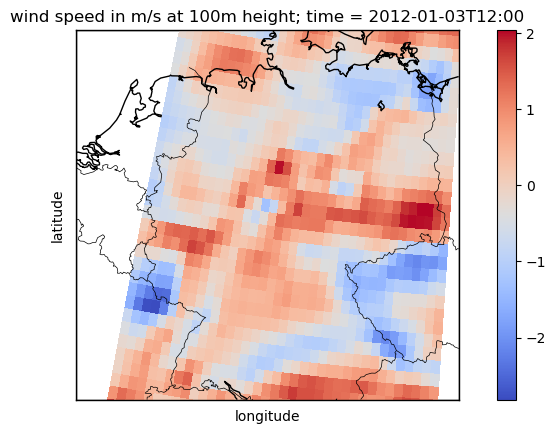

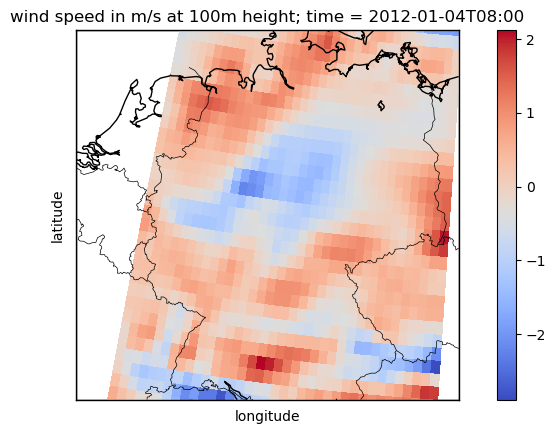

In [33]:
# error plot for specific time
time_point = 10
for time_point in range(0,100,20):
    true_val = ws100[time_point,:,:]
    approx_val = pca.inverse_transform(X_red).reshape(Y.shape)[time_point,:,:] #np.matmul(X_20, pca.components_)
    error = approx_val - true_val

    lon, lat = np.meshgrid(lons, lats)
    xi, yi = m(lon, lat)

    m = Basemap(llcrnrlon=5,llcrnrlat=47,urcrnrlon=15,urcrnrlat=55,
                resolution='i', projection='tmerc', lat_0 = 80, lon_0 = 20)
    cs = m.pcolor(xi, yi, error, cmap='coolwarm')
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()
    cbar = m.colorbar(cs, location='right', pad="10%")
    tt = np.array(time[time_point], dtype='datetime64[m]') #10 & 4378
    plt.title('wind speed in m/s at 100m height; time = '+str(tt))
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.show()

0


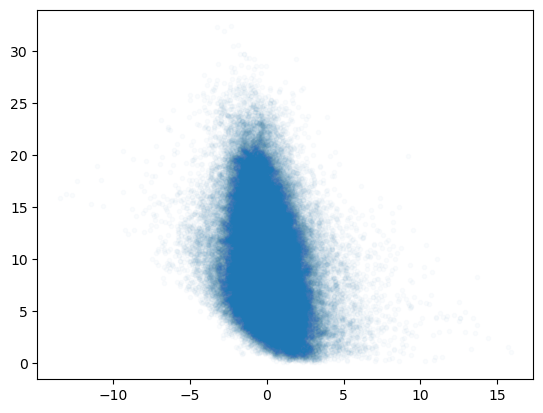

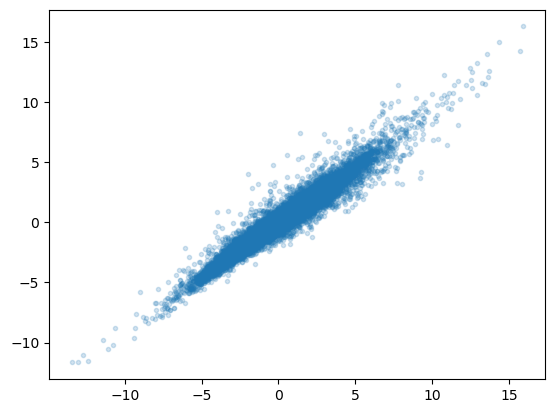

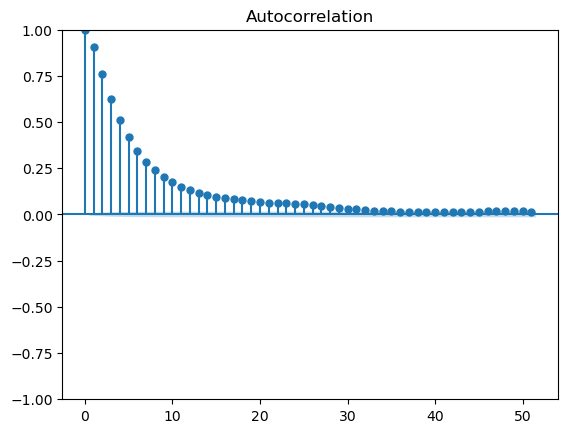

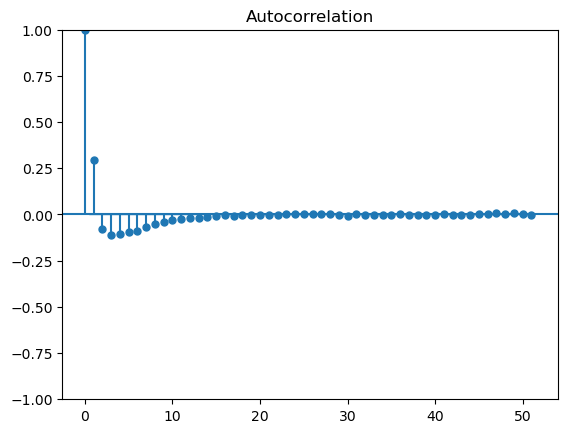

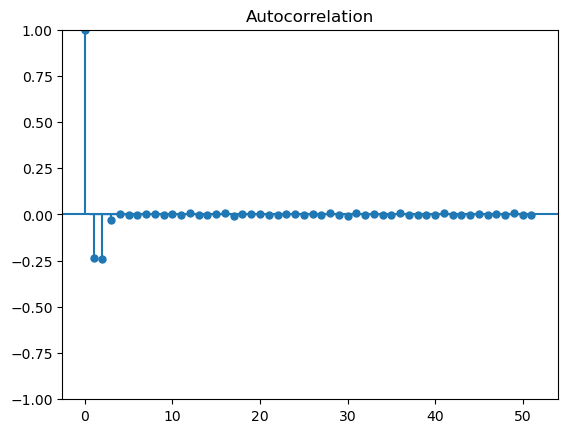

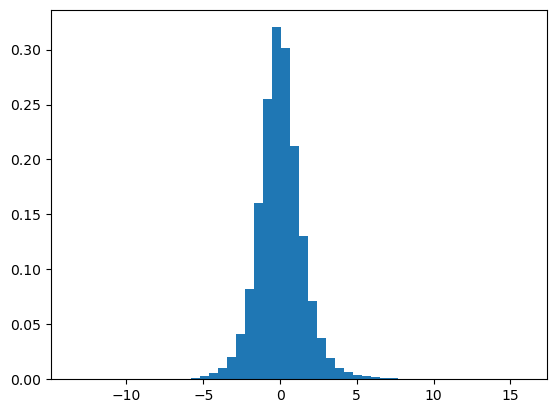

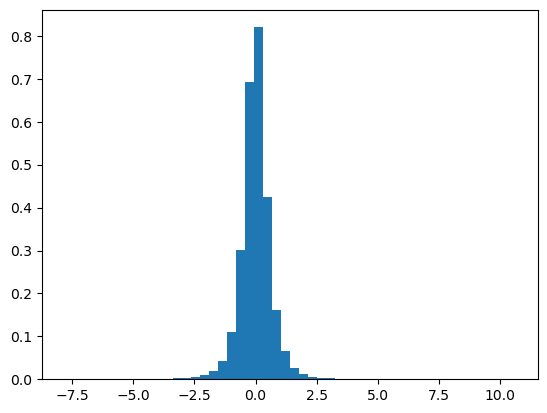

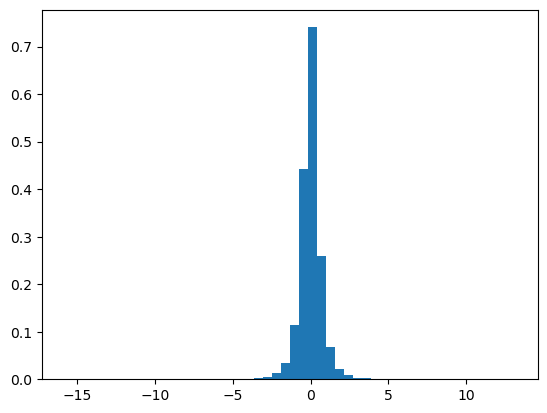

In [19]:
from statsmodels.graphics.tsaplots import plot_acf

#nan_idx = np.argwhere(~np.isnan(ws100[:,0,0])).T[0] #11:-1545
true_val = ws100[nan_idx,:,:].reshape(X.shape) # [time_point,loc0,loc0]
approx_val = pca.inverse_transform(X_red)#.reshape(Y.shape)
error = approx_val - true_val

for i in[0]: # location

    plt.figure()
    plt.plot(error[:,i], true_val[:,i], '.', alpha=0.02) #scatter plot: error vs. true value
    plt.show()

    plt.figure()
    plt.plot(error[:,i], error[:,i+1], '.', alpha=0.2) #scatter plot: error at two locations
    plt.show()

    #difference to last hour / second diff (diff of diff)
    df = pd.DataFrame(error)
    df1 = pd.DataFrame({'data': df.loc[:,i]})
    df1['data_diff'] = df1['data'] - df1['data'].shift(-1).rolling(1).mean()
    df1['data_sec_diff'] = df1['data_diff'] - df1['data_diff'].shift(-1).rolling(1).mean()

    #autocorrelation
    plot_acf(df1['data']); #column, time: 102264 
    plot_acf(df1['data_diff'][:-1])
    plot_acf(df1['data_sec_diff'][:-2])

    #histogram of error
    plt.figure()
    plt.hist(error[:,i], bins=50, density=True)
    plt.show()

    plt.figure()
    plt.hist(df1['data_diff'], bins=50, density=True)
    plt.show()

    plt.figure()
    plt.hist(df1['data_sec_diff'], bins=50, density=True)
    plt.show()

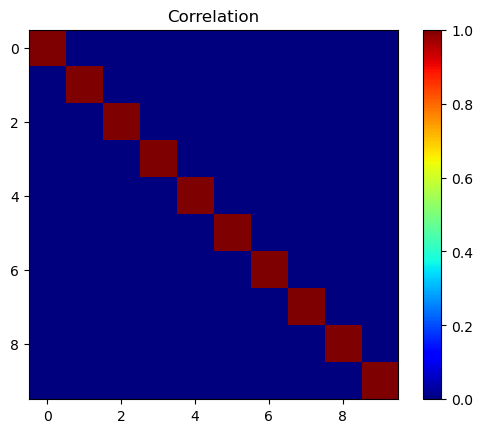

In [30]:
#correlation
corr_matrix = np.corrcoef(X_red.T)

plt.imshow(corr_matrix, cmap='jet')
plt.colorbar()
plt.title('Correlation')
plt.show()

### Correlation

In [27]:
# correlation between locations
nan_idx = np.argwhere(~np.isnan(ws100[:,0,0])).T[0]
ws100_deseasonalized = ws100[nan_idx,:,:]
for loc1 in range(len(lats)):
    for loc2 in range(len(lons)):
        ws100_deseasonalized[:,loc1,loc2], _ = deseasonalize_data(time=time_frac, data=ws100, loc1=loc1, loc2=loc2, plot=False)
all_places = ws100_deseasonalized.reshape(ws100_deseasonalized.shape[0], -1) #loc: :,::3,::3

In [28]:
corr_matrix = np.corrcoef(all_places.T)

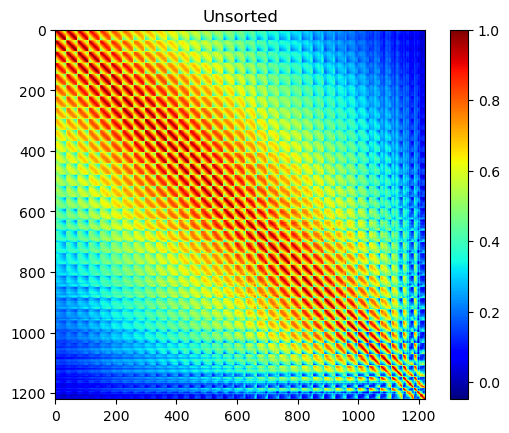

In [29]:
plt.imshow(corr_matrix, cmap='jet')
plt.colorbar()
plt.title('Unsorted')
plt.show()

In [30]:
from sklearn.cluster import AgglomerativeClustering

X_ = np.sqrt(2.0*(1.0-corr_matrix))

agg_clustering = AgglomerativeClustering(n_clusters=15, affinity='precomputed', linkage='complete')
X_pred = agg_clustering.fit_predict(X_)

/Users/angelina/opt/anaconda3/envs/climate/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


/var/folders/bx/qjxl0fz114l3hj7mhmxrcldc0000gn/T/ipykernel_38791/1674396595.py:7: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  cs = m.pcolor(xi, yi, X_pred_locs, cmap=cmap)


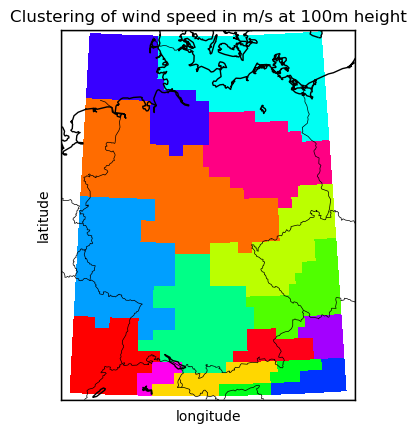

In [31]:
X_pred_locs = X_pred.reshape(ws100_deseasonalized.shape[1],ws100_deseasonalized.shape[2])

m = Basemap(llcrnrlon=5.6,llcrnrlat=46.7,urcrnrlon=16.5,urcrnrlat=55.1, resolution='i', projection='tmerc', lat_0 = 80, lon_0 = 10)
lon, lat = np.meshgrid(lons, lats)
xi, yi = m(lon, lat)
cmap = plt.cm.get_cmap('hsv', np.unique(X_pred_locs)[-1]+1)
cs = m.pcolor(xi, yi, X_pred_locs, cmap=cmap)

m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
plt.title('Clustering of wind speed in m/s at 100m height')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

In [34]:
cluster_centres = np.empty((agg_clustering.n_clusters_), dtype=int)
for i in range(agg_clustering.n_clusters_):
    this_cluster = np.where(agg_clustering.labels_ == i)[0]
    cluster_places = all_places[:,this_cluster]
    cluster_cov = np.corrcoef(cluster_places.T)
    cluster_X_ = np.sqrt(2.0*(1.0-cluster_cov))
    row_sums = cluster_X_.sum(axis=1)
    cluster_centre_local = np.argmin(row_sums)
    cluster_centres[i] = this_cluster[cluster_centre_local]

/var/folders/bx/qjxl0fz114l3hj7mhmxrcldc0000gn/T/ipykernel_38791/3201599617.py:7: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  cs = m.pcolor(xi, yi, X_pred_locs, cmap=cmap)


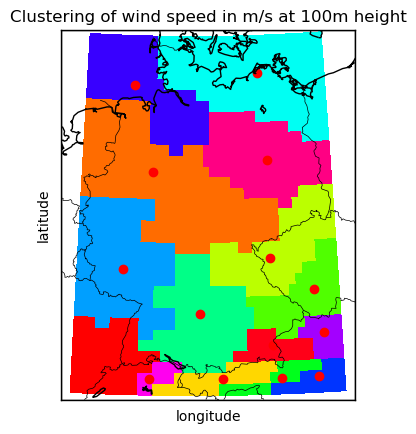

In [35]:
X_pred_locs = X_pred.reshape(ws100_deseasonalized.shape[1],ws100_deseasonalized.shape[2])

m = Basemap(llcrnrlon=5.6,llcrnrlat=46.7,urcrnrlon=16.5,urcrnrlat=55.1, resolution='i', projection='tmerc', lat_0 = 80, lon_0 = 10)
lon, lat = np.meshgrid(lons, lats)
xi, yi = m(lon, lat)
cmap = plt.cm.get_cmap('hsv', np.unique(X_pred_locs)[-1]+1)
cs = m.pcolor(xi, yi, X_pred_locs, cmap=cmap)

x_c, y_c = m(lon.flatten()[cluster_centres], lat.flatten()[cluster_centres])
plt.plot(x_c, y_c,'ro')

m.drawcoastlines()
m.drawmapboundary()
m.drawcountries()
plt.title('Clustering of wind speed in m/s at 100m height')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

In [32]:
def compute_serial_matrix(dist_mat, mat, model):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    from scipy.spatial.distance import pdist, squareform
    def seriation(Z,N,cur_index):
        '''
            input:
                - Z is a hierarchical tree (dendrogram)
                - N is the number of points given to the clustering process
                - cur_index is the position in the tree for the recursive traversal
            output:
                - order implied by the hierarchical tree Z

            seriation computes the order implied by a hierarchical tree (dendrogram)
        '''
        if cur_index < N:
            return [cur_index]
        else:
            left = int(Z[cur_index-N,0])
            right = int(Z[cur_index-N,1])
            return (seriation(Z,N,left) + seriation(Z,N,right))
    
    def create_linkage_matrix(X, model, mode='l2'):
        distances = []
        weights = []
        children=model.children_
        dims = (X.shape[1],1)
        distCache = {}
        weightCache = {}
        for childs in children:
            c1 = X[childs[0]].reshape(dims)
            c2 = X[childs[1]].reshape(dims)
            c1Dist = 0
            c1W = 1
            c2Dist = 0
            c2W = 1
            if childs[0] in distCache.keys():
                c1Dist = distCache[childs[0]]
                c1W = weightCache[childs[0]]
            if childs[1] in distCache.keys():
                c2Dist = distCache[childs[1]]
                c2W = weightCache[childs[1]]
            d = np.linalg.norm(c1-c2)
            cc = ((c1W*c1)+(c2W*c2))/(c1W+c2W)

            X = np.vstack((X,cc.T))

            newChild_id = X.shape[0]-1

            # How to deal with a higher level cluster merge with lower distance:
            if mode=='l2':  # Increase the higher level cluster size suing an l2 norm
                added_dist = (c1Dist**2+c2Dist**2)**0.5 
                dNew = (d**2 + added_dist**2)**0.5
            elif mode == 'max':  # If the previrous clusters had higher distance, use that one
                dNew = max(d,c1Dist,c2Dist)
            elif mode == 'actual':  # Plot the actual distance.
                dNew = d

            wNew = (c1W + c2W)
            distCache[newChild_id] = dNew
            weightCache[newChild_id] = wNew

            distances.append(dNew)
            weights.append(wNew)
        linkage_matrix = np.column_stack([model.children_, distances, weights]).astype(float)
        return linkage_matrix
    N = len(dist_mat)
    #flat_dist_mat = squareform(dist_mat)
    #res_linkage = linkage(flat_dist_mat, method=method,preserve_input=True)
    res_linkage = create_linkage_matrix(dist_mat,model)
    res_order = seriation(res_linkage, N, N + N-2)
    #seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    result = np.copy(mat)
    result[a,b] = result[ [res_order[i] for i in a], [res_order[j] for j in b]]
    result[b,a] = result[a,b]
    
    return result, res_order, res_linkage

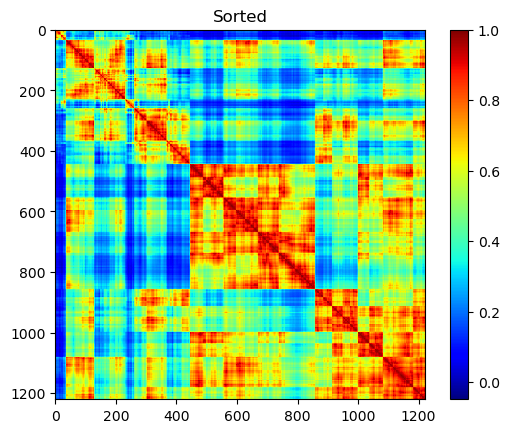

In [33]:
ordered_corr, res_order, res_linkage = compute_serial_matrix(X_, corr_matrix, agg_clustering)
plt.imshow(ordered_corr, cmap='jet')
plt.colorbar()
plt.title('Sorted')
plt.show()

### 1D Fourier

/Users/angelina/opt/anaconda3/envs/climate/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


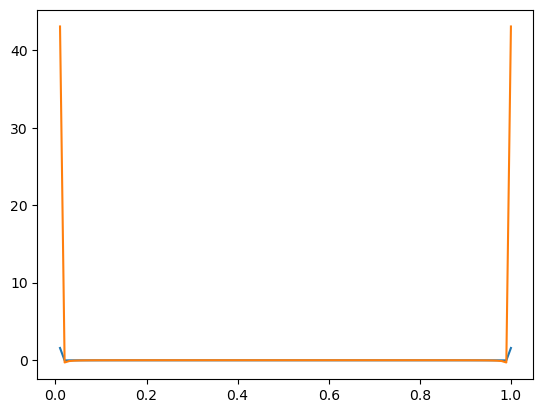

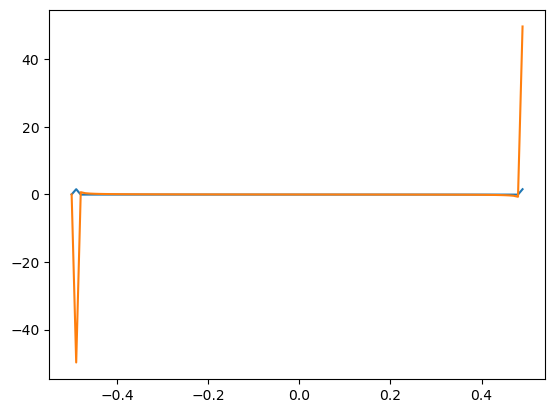

In [36]:
import scipy.fft
x = np.linspace(0,1,100)
y = np.sin(2*np.pi*x) #sin(2pix) -> [0,1]
y2 = np.sin(2*np.pi*x + 1) #sin(2pix+1) -> [0,1]
zs = scipy.fft.fft(y)
zs2 = scipy.fft.fft(y2)
freq = scipy.fft.fftshift(scipy.fft.fftfreq(x.shape[-1]))

plt.figure()
plt.plot(x[1:], zs[1:])
plt.plot(x[1:], zs2[1:])
plt.show()

plt.figure()
plt.plot(freq, zs.real, freq, zs.imag)
plt.show()

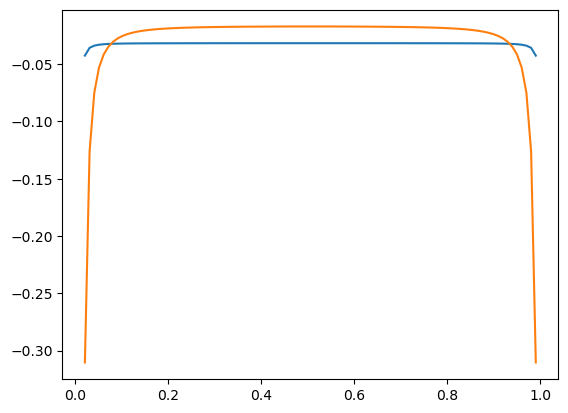

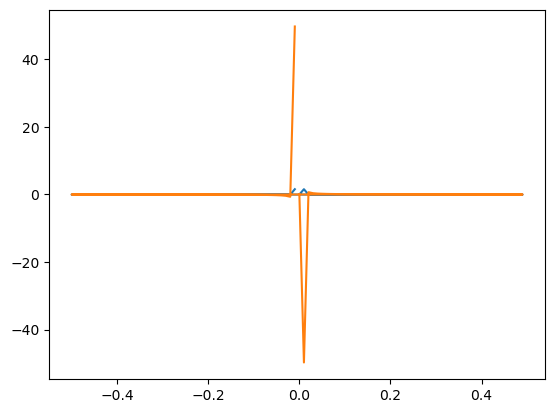

In [37]:
x = x = np.linspace(0,1,100)
y = np.sin(2*np.pi*x) #sin(2pix) -> [0,1]
y2 = np.sin(2*np.pi*x + 1) #sin(2pix+1) -> [0,1]
z = np.fft.fft(y)
z2 = np.fft.fft(y2)
freq = np.fft.fftfreq(x.shape[-1])

plt.figure()
plt.plot(x[2:-1], z[2:-1])
plt.plot(x[2:-1], z2[2:-1])
plt.show()

plt.figure()
plt.plot(freq, z.real, freq, z.imag)
plt.show()


# Brown et al. 1984

In [ ]:
import scipy.stats as s

N=30
x1 = ws100[0:2*24*365,loc1,loc1]
counts, bins = np.histogram(x1, bins=N)
bin_width = bins[1]-bins[0]
total_count = float(sum(counts))

f, ax = plt.subplots(1, 1)

ax.bar(bins[:-1]+bin_width/2., counts, align='center', width=.85*bin_width)
ax.grid('on')
def fit_pdf(x, name='weibull_min', color='r'):
    dist = getattr(s, name)  # params = shape, loc, scale
    params = s.weibull_min.fit(x, floc=0)  # 1-day lag minimum for shipping
    print(params)
    y = dist.pdf(bins, *params)*total_count*bin_width
    sqerror_sum = np.log(sum(ci*(yi - ci)**2. for (ci, yi) in zip(counts, y)))
    ax.plot(bins, y, color, lw=3, alpha=0.6, label='%s   err=%3.2f' % (name, sqerror_sum))
    return y

colors = ['r-', 'g-', 'r:', 'g:']

for name, color in zip(['weibull_min'], colors): # 'lognorm', 'erlang', 'chi2', 'weibull_min', 
    y = fit_pdf(x1, name=name, color=color)

ax.legend(loc='best', frameon=False)
sel_lon = np.array(lons[loc1])
sel_lat = np.array(lats[loc1])
plt.title('Histogram of wind speed at '+'Longitude = '+str(sel_lon)+'; Latitude = '+str(sel_lat))
plt.show()


x2 = ws100[0:2*24*365,loc2,loc2]
counts, bins = np.histogram(x2, bins=N)
bin_width = bins[1]-bins[0]
total_count = float(sum(counts))

f, ax = plt.subplots(1, 1)

ax.bar(bins[:-1]+bin_width/2., counts, align='center', width=.85*bin_width)
ax.grid('on')
def fit_pdf(x, name='weibull_min', color='r'):
    dist = getattr(s, name)  # params = shape, loc, scale
    params = s.weibull_min.fit(x, floc=0)  # 1-day lag minimum for shipping
    print(params)
    y = dist.pdf(bins, *params)*total_count*bin_width
    sqerror_sum = np.log(sum(ci*(yi - ci)**2. for (ci, yi) in zip(counts, y)))
    ax.plot(bins, y, color, lw=3, alpha=0.6, label='%s   err=%3.2f' % (name, sqerror_sum))
    return y

colors = ['r-', 'g-', 'r:', 'g:']

for name, color in zip(['weibull_min'], colors): # 'lognorm', 'erlang', 'chi2', 'weibull_min', 
    y = fit_pdf(x2, name=name, color=color)

ax.legend(loc='best', frameon=False)
sel_lon = np.array(lons[loc2])
sel_lat = np.array(lats[loc2])
plt.title('Histogram of wind speed at '+'Longitude = '+str(sel_lon)+'; Latitude = '+str(sel_lat))
plt.show()



In [ ]:
# statistical overview over distribution of wind time series
N=30
x1 = ws100[0:2*24*365,loc1,loc1]
counts, bins = np.histogram(x1, bins=N)
bin_width = bins[1]-bins[0]
total_count = float(sum(counts))


def fit_pdf(x, name='weibull_min', color='r'):
    dist = getattr(s, name)  # params = shape, loc, scale
    params = s.weibull_min.fit(x, floc=0)  # 1-day lag minimum for shipping
    #y = dist.pdf(bins, *params)*total_count*bin_width
    #sqerror_sum = np.log(sum(ci*(yi - ci)**2. for (ci, yi) in zip(counts, y)))
    #ax.plot(bins, y, color, lw=3, alpha=0.6, label='%s   err=%3.2f' % (name, sqerror_sum))
    return params

colors = ['r-', 'g-', 'r:', 'g:']

for name, color in zip(['weibull_min'], colors): # 'lognorm', 'erlang', 'chi2', 'weibull_min', 
    for i in range(33):
        x1 = ws100[0:2*24*365,i,i]
        params = fit_pdf(x1, name=name, color=color)
        print(params)


In [ ]:
# deseasonalization
mu = []
for i in range(0,24):
    mu.append(0)
    count = 0
    for j in range(i,len(x1)-24,24):
        mu[i] = mu[i] + x1[j]
        count = count + 1

    mu[i] = mu[i]/count

print(mu)

sigma = []
for i in range(0,24):
    sigma.append(0)
    count = 0
    for j in range(i,len(x1)-24,24):
        sigma[i] = sigma[i] + (x1[j] - mu[i])**2
        count = count + 1

    sigma[i] = np.sqrt(sigma[i]/count)

for i in range(0,24):
    for j in range(i,len(x1)-24,24):
        x1[j] = (x1[j] - mu[i])/sigma[i]

plt.figure(figsize=(15,5))
plt.plot(time[0:2*24*365],x1)
sel_lon = np.array(lons[15])
sel_lat = np.array(lats[15])
plt.title('Longitude = '+str(sel_lon)+'; Latitude = '+str(sel_lat))
plt.ylabel('Deseasonalized wind speed in m/s')
plt.xlabel('time')
plt.show()

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(x1, bins='auto', density=True)
ax.set_ylabel('Probability')
ax.set_title('Distribution of deseasonalized wind speed')
ax.legend();

#box cox transformation (transform data to normal distribution)
from scipy.special import boxcox, inv_boxcox
x_trans = s.yeojohnson(x1,0.5)

xt = x_trans


plt.figure(figsize=(15,5))
plt.plot(time[0:2*24*365],xt)
sel_lon = np.array(lons[15])
sel_lat = np.array(lats[15])
plt.title('Longitude = '+str(sel_lon)+'; Latitude = '+str(sel_lat))
plt.ylabel('Deseasonalized and transformed wind speed in m/s')
plt.xlabel('time')
plt.show()


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
#The autocorrelation function decays exponentially for an AR time series at a rate of the AR parameter.
plot_acf(xt,lags = 100)
#One useful tool to identify the order of an AR model is to look at the Partial Autocorrelation Function (PACF)
plot_pacf(xt)

# visual inspection

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(xt, bins='auto', density=True)
ax.set_ylabel('Transformed Probability')
ax.set_title('Yeo-Johnson Transformed Distribution of deseasonalized wind speed')
ax.legend();

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

prob = s.probplot(x1, dist=s.norm, plot=ax1)
prob = s.probplot(xt, dist=s.norm, plot=ax2)

ax1.set_title('Original Data')
ax1.set_ylabel('Wind Speed')
ax2.set_title('Transforamed Data, λ = 0.5');
ax2.set_ylabel('');


In [ ]:
train= x1[:24*365]
test= x1[365*24:2*365*24]

from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df, train_len, horizon, window):
    
    total_len = train_len + horizon
    end_idx = train_len
    
    pred_AR = []

     
    for i in range(train_len, total_len, window):
        model = SARIMAX(df[:i], order=(2,0,0))
        res = model.fit(disp=False) 
        predictions = res.get_prediction(0, i + window -1 )
        oos_pred = predictions.predicted_mean[-window:]
        pred_AR.extend(oos_pred)
            
    return pred_AR

train_len = 24*365
horizon = 24*2
window = 1
pred_AR = rolling_forecast(xt, train_len, horizon, window)

print(len(pred_AR))

plt.figure(figsize=(15,5))
#plt.plot(time[0:2*24*365],xt,label='data')
plt.plot(time[0:train_len],xt[0:train_len],label='train')
plt.plot(time[train_len:train_len+horizon],xt[train_len:train_len+horizon],label='test')
plt.plot(time[train_len:train_len+horizon],pred_AR,label='AR(2) model')
plt.legend()

plt.figure(figsize=(15,5))
#plt.plot(time[0:2*24*365],xt,label='data')
#plt.plot(time[0:train_len],xt[0:train_len],label='train')
plt.plot(time[train_len:train_len+horizon],xt[train_len:train_len+horizon],label='test')
plt.plot(time[train_len:train_len+horizon],pred_AR,label='AR(2) model')
plt.legend()


In [ ]:
x_new=[x for n in (xt[0:24*365],pred_AR) for x in n]


# invert a yeojhonson transform for one value
def invert_yeojhonson(value, lmbda):
  if value>= 0 and lmbda == 0:
    return np.exp(value) - 1
  elif value >= 0 and lmbda != 0:
    return (value * lmbda + 1) ** (1 / lmbda) - 1
  elif value < 0 and lmbda != 2:
    return 1 - (-(2 - lmbda) * value + 1) ** (1 / (2 - lmbda))
  elif value < 0 and lmbda == 2:
    return 1 - np.exp(-value)
  
xrt = [invert_yeojhonson(x, 0.5) for x in x_new]


for i in range(0,24):
    for j in range(i,len(xrt)-24,24):
        xrt[j] = xrt[j]*sigma[i] + mu[i]


plt.figure(figsize=(15,5))
#plt.plot(time[0:2*24*365],xt,label='data')
plt.plot(time[0:train_len+horizon],x1[0:train_len+horizon],label='Original data')
plt.plot(time[train_len:train_len+horizon],xrt[train_len:train_len+horizon],label='Predicted data')
plt.ylabel('wind speed in m/s')
plt.xlabel('time')
plt.title('Time series of wind speed at '+'Longitude = '+str(sel_lon)+'; Latitude = '+str(sel_lat))
plt.legend()

# OU-Process


In [ ]:
plt.figure(figsize=(15,5))
plt.plot(time[:],ws100[:,loc1,loc1])
sel_lon = np.array(lons[loc1])
sel_lat = np.array(lats[loc1])
plt.title('Longitude = '+str(sel_lon)+'; Latitude = '+str(sel_lat))
plt.ylabel('wind speed in m/s')
plt.xlabel('time')
plt.show()

In [ ]:
# deseasonalize by fitting 
# a_1 + a_2 sin(2*pi*t/365) + a_3 cos(2*pi*t/365)
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
xdata = np.linspace(0, 1*365*24,1*365*24)
ydata = ws100[0:1*365*24,loc1,loc1]

mu = []
for i in range(0,24):
    mu.append(0)
    count = 0
    for j in range(i,len(ydata)-24,24):
        mu[i] = mu[i] + ydata[j]
        count = count + 1

    mu[i] = mu[i]/count

print(mu)

sigma = []
for i in range(0,24):
    sigma.append(0)
    count = 0
    for j in range(i,len(ydata)-24,24):
        sigma[i] = sigma[i] + (ydata[j] - mu[i])**2
        count = count + 1

    sigma[i] = np.sqrt(sigma[i]/count)

for i in range(0,24):
    for j in range(i,len(ydata)-24,24):
        ydata[j] = (ydata[j] - mu[i])/sigma[i]



def func(x, a, b, c,d,e):
    return a + b* np.sin(c*2.*np.pi * x/(365.)) + d* np.cos(e*2.*np.pi * x/(365.))

popt, pcov = curve_fit(func, xdata, ydata)
print(popt)

plt.figure(figsize=(15,5))
plt.plot(time[0:1*365*24], ydata, 'b-', label='data')
plt.plot(time[0:1*365*24], func(xdata, *popt))



ydes = ydata - func(xdata, *popt)

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
#The autocorrelation function decays exponentially for an AR time series at a rate of the AR parameter.
plot_acf(ydes,lags = 100)
#One useful tool to identify the order of an AR model is to look at the Partial Autocorrelation Function (PACF)
plot_pacf(ydes)




plt.figure(figsize=(15,5))
plt.plot(time[0:1*365*24], ydes, 'b-', label='data')
#plt.plot(time[0:1*365*24], func(xdata, *popt))

